# Dit Notebook bevat een nadere onderbouwing en uitwerking van concepten voor analytisvche berekening van grondwatersstandswijzigingen in de Voortoets van Agentschap Natuur en Bos (Vlaamse Overheid) en vormt aldus een bijdrage aan de door ANB gewenste nadere beschouwing van het screeningsinstrument met het oog op eventuele verbeteringen.

Opgesteld ter onderbouwing en illustratie van Module 3 - Inhoudelijke uitwerking van module 3 in de online toepassing van de voortoets: het bepalen van de reikwijdte van effecten voor de indirecte effectgroepen - Thema Grondwater, in 2013 beschreven in opdracht van ANB door

J. Bronders, J. Patyn, I.Van Keer, N. Desmet, J. Vos, W. Peelaerts, L. Decorte & A. Gobin


Dit notebook maakt gebruik van het pythonbestand "wellfunctionalities.py" waarin alle gebruikte grondwaterfuncties zijn geïmplementeerd
waarvan in dit notebook gebruik wordt gemaakt.


@T.N.Olsthoorn Maart 2025


In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import k0 as K0, k1 as K1, erfc, exp1
from scipy.signal import lfilter
from itertools import cycle

import wellfunctionalities as wf
import fdm3Blom
from fdm.mfgrid import Grid

from importlib import reload


# Class Dirs (namespace for de te gebruiken directories)

Class Dirs dient als namespace voor de directories waarvan gebruik worden gemaakt. Deze moeten worden aangepast aan de directory structuur op de eigen computer.

In [ ]:
class Dirs:
    """Namespace for directories in project"""
    def __init__(self):
        self.home = '/Users/Theo/Entiteiten/Hygea/2022-AGT/jupyter/'
        self.data = os.path.join(self.home, 'data')
        self.images = os.path.join(self.home, 'images')
    
dirs = Dirs()
assert os.path.isdir(dirs.data), f"{dirs.data} not found!"
assert os.path.isdir(dirs.images), f"{dirs.images} not found!"

# Test wf.Mirrors

Let op dat wf een referentie is naar de geïmporteerde "wellfunctionalities.py".

De functie wf.Mirrors genereert spiegelcoördinaten voor putten tussen twee evenwijdige lijnen.

In [ ]:

# Example, immediately shows all possibilities
kD, S, c= 600, 0.001, 200
lambda_ = np.sqrt(kD * c)

xL, xR, xw, N= -200, 200, 100, 30

# =============================================================
fig, ax = plt.subplots(figsize=(10, 6))
md = wf.Mirrors(xL, xR, xw=xw, N=N, Lclosed=False, Rclosed=False)
_ = md.show(ax=ax, figsize=(8, 2), fcs=('yellow', 'orange'))
fig.savefig(os.path.join(dirs.images, "put_spiegelschema.png"))
# =============================================================
Q = -1200.
n = 0
L = xR - xL
x = np.linspace(xL - n * L, xR + n * L, 121)

# Regular
s = np.zeros_like(x)
r = np.sqrt((md.xw - x) ** 2)
s = md.sw * Q / (2 * np.pi * kD) * K0( r / lambda_)
for xw, sgn in zip(md.xLD, md.sLD):
    r = np.sqrt((xw - x) ** 2)
    s += sgn * Q / (2 * np.pi * kD) * K0(r / lambda_)
for xw, sgn in zip(md.xRD, md.sRD):
    r = np.sqrt((xw - x) ** 2)
    s += sgn * Q / (2 * np.pi * kD) * K0(r / lambda_)
s1 = s
    
# Met deGlee class
dGlee = wf.wDeGlee(xw=md.xw, yw=0., aqprops={'kD': kD, 'lambda': lambda_})

s = np.zeros_like(x)

s = dGlee.dd(x=x, Q=Q)
for xw, sgn in zip(md.xLD, md.sLD):
    dGlee.xw = xw
    s += dGlee.dd(x=x, Q= sgn * Q)
for xw, sgn in zip(md.xRD, md.sRD):
    dGlee.xw = xw
    s += dGlee.dd(x=x, Q= sgn * Q)
s2 = s
 
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_title("Result of flow caused by a well between fixed boundaries")
ax.set(xlabel="x [m]", ylabel='head [m]')
ax.plot(x, s1, label="Direct")
ax.plot(x, s2, '.', label="Via class")
ax.grid()
ax.legend()
fig.savefig(os.path.join(dirs.images, "put_in_strip_spiegelen.png"))
plt.show()

# Gebruik wf.Mirrors ook om sloten te spiegelen

Voorbeeld is het gebruik van Mirrors voor het berekenen van de drainage van een grondwaterbasin (strip land tussen evenwijdige randen).

In [ ]:
kD, S = 600., 0.2
xL, xR, AL, AR = -100., 100., 1.0, 1.0
b = (xR - xL) / 2
T50 = 0.28 * b ** 2 * S / kD

ts = np.arange(7) * T50
ts[0] = 0.01 * T50
x = np.linspace(xL, xR, 201)

md = wf.Mirrors(xL, xR, N=30, Lclosed=False, Rclosed=False)
_, ax = plt.subplots(figsize=(8, 6))
ax.set_title(f"Basin kD={kD} m2/d, S={S}, T50={T50:.4g} d")
ax.set(xlabel="x [m]", ylabel="head [m]")
for t in ts:
    s = np.zeros_like(x)
    xM = 0.5 * (xL + xR)
    for xD, sgn in zip(md.xLD, md.sLD):
        x_ = xD - x if xD >= xM else x - xD
        u = x_ * np.sqrt(S / (4 *  kD * t))
        s += sgn * AL * erfc(u)
    for xD, sgn in zip(md.xRD, md.sRD):
        x_ = xD - x if xD >= xM else x - xD
        u = x_ * np.sqrt(S / (4 *  kD * t))
        s += sgn * AR * erfc(u)
    ax.plot(x, s, label=f"t = {t:.3f} = {t/T50:.4g} T50d")
ax.grid()
ax.legend(loc="lower right")
fig.savefig(os.path.join(dirs.images, "bassin_drainage_spiegel_sloten.png"))
plt.show()

    

# Put in een strip land met harde stijghoogteranden

De velaging wordt berekend door de put voldoende vaak te spiegelen om beide randen.

In [ ]:
# reload(wf)

N, kD = 0.001, 20 * 50
lamb_L, lamb_R = 200., 300.
aqprops = {'kD': kD, 'lambda_L': lamb_L, 'lambda_R': lamb_R}

xL, xR, hL, hR = -2500., 2500., 20., 22.
boundaries={'xL': xL, 'xR': xR, 'hL': hL, 'hR': hR}

Q = -1200 # m3/d

x = np.linspace(xL - 500., xR + 500., 6000)
y = np.zeros_like(x)

xW, yW = xM - 1000., 0.

L = xR - xL
sect1 = wf.Section(boundaries=boundaries, aqprops={'kD': kD, 'lambda_L': 0., 'lambda_R': 0.})
sect2 = wf.Section(boundaries=boundaries, aqprops={'kD': kD, 'lambda_L': 0., 'lambda_R': 0.})
h1 = sect1.h(x=x, N=N)
h2 = sect2.h(x=x, N=N)

title=f"Gebied tussen twee rechte randen met gefixeerde stijghoogte en onttrekking, kD={kD}"
fig, ax = plt.subplots(figsize=(10, 6))
ax.set(title=title, xlabel="x [m]", ylabel="TAW [m]")
ax.grid()

ax.plot(x, h1, label="zonder put, alleen N")
ax.plot(x[::10], wf.ground_surface(x[::10], xL=xL, xR=xR, yM=1, Lfilt=8) + h1[::10], label='maaiveld')

# Get the well positions
md = wf.Mirrors(xL=xL, xR=xR, xw=xW, N=5)
# md.show()

yld = yrd = 0.

# The real (actual well:
lambda_ = 3000.
R = lambda_ * 3
wGlee   = wf.wDeGlee(xw=md.xw, yw=yW, aqprops={'kD': kD, 'lambda': lambda_})
wDupuit = wf.wDupuit(xw=md.xw, yw=yW, aqprops={'kD': kD})


# We can also use leaky aquifer which ensures the drawdown approaches zero at infinity
sG = wGlee.dd(  x=x, Q=Q)
sD = wDupuit.dd(x=x, Q=Q, R=R)
# Add the effect of all the mirror wells
for i, (xld, sld, xrd, srd) in enumerate(zip(md.xLD, md.sLD, md.xRD, md.sLD)):
    wGlee.xw   = xld
    wDupuit.xw = xld
    sG += wGlee.dd(  x=x, Q= sld * Q)
    sD += wDupuit.dd(x=x, Q= sld * Q, R=R)
    wGlee.xw   = xrd
    wDupuit.xw = xrd
    sG += wGlee.dd(  x=x, Q= srd * Q)
    sD += wDupuit.dd(x=x, Q= srd * Q, R=R)
    
ax.plot(x, h1 + sG, label=fr"De Glee ($\lambda = {lambda_:.0f}\, m$)")
ax.plot(x, h1 + sD, label=fr"Dupuit ($R={R:.0f}\, m$")
ax.annotate('Onttrekking', xy=(md.xw, 20), xytext=(md.xw, 24.5), ha='center', arrowprops={'arrowstyle': '<-', 'lw': 1.5} )
ax.legend(loc="lower right")
ax.plot([xL, xR], [hL, hR], 'ro', label='Vaste stijghoogtes')

fig.savefig(os.path.join(dirs.images, "puntbron_hantush_strip_A.png"), transparent=True)
plt.show()


# Nader beeld van het spiegelen

Door ook coordinaten rechts en links van de strip te laten zien, wordt getoond hoe het spiegelijk werkt.

In [ ]:
# Grondwaterstanden contourlijnen
def fmt(x):
    s = f"{x:.1f}"
    if s.endswith('0'):
        s = f"{x:.0f}"
    return f"{s}"

x = np.linspace(-15000, 15000, 301)
y = np.linspace(-3000, 3000, 301)
X, Y = np.meshgrid(x, y)

kD, S, xL, xR, xw, yw = 600., 0.2, -2500, 2500., -1500., 0.

md = wf.Mirrors(xL=xL, xR=xR, xw=xw, N=100)

lambda_ = 6000. # Fixtieve zeer hoge spreidingslengte
R = 3 * lambda_

Q = -1200 # m3/d

# Using K0 to make sure dd goes to zero for very large r
# With log, we don't get zero drawdown along both canals, only near y=0

dGlee = wf.wDeGlee( xw=xw, yw=yw, aqprops={'kD': kD, 'lambda': lambda_})
dupuit = wf.wDupuit(xw=xw, yw=yw, aqprops={'kD': kD})

sG = dGlee.dd( x=X, Q=Q)
sD = dupuit.dd(x=X, Q=Q, R=R)

# Add the effect of all the mirror wells
for xl, sl, xr, sr in zip(md.xLD, md.sLD, md.xRD, md.sLD):
    dGlee.xw  = xl
    dupuit.xw = xl
    sG += dGlee.dd(x=X, Q=sl * Q)
    sD += dupuit.dd(x=X, Q=sl * Q, R=R)
    
    dGlee.xw  = xr
    dupuit.xw = xr
    sG += dGlee.dd( x=X, Q=sr * Q)    
    sD += dupuit.dd(x=X, Q=sr * Q, R=R)
    
# Set levels to contour
levels = hL + np.arange(0, 6., 0.2)


title=fr"Doorsnede van de grwst. verlaging (toont spiegelen). $kD={kD:.0f}\,m^2/d$"

fig, ax = plt.subplots(figsize=(10, 6))
ax.set(title=title, xlabel="x [m]", ylabel="y [m]")
ax.plot(X[Y[:, 0]==0][0], sG[Y[:,0]==0][0], label=fr"De Glee, $\lambda={lambda_} m$") 
ax.plot(X[Y[:, 0]==0][0], sD[Y[:,0]==0][0], label=fr"Dupuit,  $R = {R} m$")

ax.annotate('Sloot links', [xL, -1], xytext=[xL, 0.55],
            ha='center', arrowprops={'arrowstyle': '-', 'lw': 0.75, 'color': 'black'})
ax.annotate('Sloot rechts', [xR, -1], xytext=[xR, 0.55],
            ha='center', arrowprops={'arrowstyle': '-', 'lw': 0.75, 'color': 'black'})
ax.annotate(fr"$Q={Q}\,m^3/d$", xy=(md.xw, -1.5), xytext=(md.xw, 0.2),
            ha='center', arrowprops={'arrowstyle': '<-', 'lw': 3, 'color': 'red'})
ax.annotate('Spiegelput L1', xy=(md.xLD[0], 1.0), xytext=(md.xLD[0], 1.5),
            ha='center', arrowprops={'arrowstyle': '->', 'lw': 3, 'color': 'green'})
ax.annotate('Spiegelput R1. Mirror well R1', xy=(md.xRD[0], 1.0), xytext=(md.xRD[0], 1.5),
            ha='center', arrowprops={'arrowstyle': '->', 'lw': 3, 'color': 'green'})

ax.grid()
ax.set_ylim(-2, 2) # Ensure arrows are completely visible.
ax.legend(loc="lower right", fontsize="x-small")
fig.savefig(os.path.join(dirs.images, "section_spiegelen.png"))
plt.show()


# Bruggeman, een gebied gaat over in een ander gebied.

Oplossing 370.01 van Bruggmman (1999) beschrijft de verlaging door een put in een semi-gespannen pakket waarvan de eigenschappen kD en c verspringen op de lijn x=0. Deze oplossing biedt de mogelijk om de invloed te berekenen van een put nabij de grens van een hoog droog naar een lager nat gebied.

Voor $x<0$ geldt $k_2D_1$ en $c_1$ zonder onttrekking, terwijl voor $x>0$ $k_2D_2$ en $c_2$ gelden met onttrekking $Q$ op $x=a$. Op $x=0$ geldt dat de stijghoogte voor $x<0$, $\phi_1$ gelijk is aan die voor $x>0$, $\phi_2$ en dat het specifiek debiet in de $x$-richting  $q_x$ daar continue is.

In [ ]:
# reload(wf)
kD1, kD2, c1, c2 = 600., 600., 5000, 50.
L1, L2 = np.sqrt(kD1 * c1), np.sqrt(kD2 * c2)
x = np.linspace(-2000, 2000, 401)
xw = 200.
Q = -1200.

title = f"Bruggeman 370_01, verification, xw={xw:.4g} m, Qw={Q:.4g} m3/d\nkD1={kD1:.4g} m2/d, kD2={kD2:.4g} m2/d, c1={c1:.4g} d, c2={c2:.4g} d"
fig, ax = plt.subplots(figsize=(10, 6))
ax.set(title=title, xlabel="x [m]", ylabel="phi [m]")
    
Br1 = wf.Brug370_1(xw=+xw, yw=0., aqprops={'kD1': kD1, 'kD2': kD2, 'c1': c1, 'c2': c2})
Br2 = wf.Brug370_1(xw=-xw, yw=0., aqprops={'kD1': kD1, 'kD2': kD2, 'c1': c1, 'c2': c2})

Br3 = wf.Brug370_1(xw=xw, yw=0., aqprops={'kD1': kD1, 'kD2': kD1, 'c1': c1, 'c2': c1})
dGl1 = wf.wDeGlee( xw=xw, yw=0., aqprops={'kD': kD1, 'c': c1})
Br4 = wf.Brug370_1(xw=xw, yw=0., aqprops={'kD1': kD2, 'kD2': kD2, 'c1': c2, 'c2': c2})
dGl2 = wf.wDeGlee( xw=xw, yw=0., aqprops={'kD': kD2, 'c': c2})

dGl1.aq['lambda'] = float(np.round(dGl1.aq['lambda'], 0))

X, Y, Phi1 = Br1.dd(x, Q=Q)    
X, Y, Phi2 = Br2.dd(x, Q=Q)

# Using same kD and c gives just De Glee
X, Y, Phi3 = Br3.dd(x, Q=Q)
PhiG1 = dGl1.dd(x, Q=Q)

# Compare with De Glee
X, Y, Phi4 = Br4.dd(x, Q=Q)
PhiG2 = dGl2.dd(x, Q=Q)

if X.ndim == 1:
    ax.plot(X, Phi1, label=fr"$x_w$={Br1.xw}, aqprops={Br1.aq}")
    ax.plot(X, Phi2, label=f"$x_w$={Br2.xw},  aqprops={Br2.aq}")
    ax.plot(X, Phi3, label=f"$x_w$={Br3.xw},  aqprops={Br3.aq}")
    ax.plot(X[::5], PhiG1[::5], '.', label=f"$x_w$={dGl1.xw},  deGlee, aqprops={dGl1.aq}")
    # ax.plot(X, Phi4, label=f"Phi4, $x_w={Br4.xw},  aqprops={Br4.aq}")
    # ax.plot(X, PhiG2, '.', label=f"Phi, $x_w={dGl2.xw},  deGlee, aprops={dGl2.aq}")
else:
    CS = ax.contour(X, Y, Phi1, levels=levels)
    ax.clabel(CS, levels=CS.levels, fmt="{:.2f}")

ax.grid()    
ax.vlines([0], -1.25, 0., 'k', ls='--', label='Gebiedsgrens')
ax.set_ylim(-2.0, 0.2)
ax.legend()
fig.savefig(os.path.join(dirs.images, "brug370_01_test.png"))
plt.show()


# Stijghoogte in een hoog gebied dat grenst aan een laag gebied met drainage.

In [ ]:
reload(wf)
xL, xR, hL, hR = -2500, 2500, 20., 22.
boundaries ={'xL': xL, 'xR': xR, 'hL': hL, 'hR': hR}
xM = (xL + xR) / 2
xW, yW = xM + 1750., 0.

Q = -4800 # m3/d

N, k, D, lamb_L, lamb_R = 0.002, 30., 20., 500., 500.
lamb_M = 12000 # Middengebied (De Glee)
aqprops1 = {'k': k, 'D': D, 'lambda_L': lamb_L, 'lambda_R': lamb_R}
aqprops2 = {'k': k, 'D': D, 'lambda_L': 0.,     'lambda_R': 0.    }

x = np.linspace(xL -1000., xR + 1000., 601)
y = np.zeros_like(x)

sec1 = wf.Section(boundaries=boundaries, aqprops=aqprops1)
sec2 = wf.Section(boundaries=boundaries, aqprops=aqprops2)

title=fr"""Stijghoogte in hoog gebied grenzend aan laag met drainage;
$kD={aqprops1['kD']:.4g}\, m^2/d,\, N={N:.4g} m/d,\, \lambda_L={aqprops1['lambda_L']:.4g}\, m, \lambda_R={aqprops1['lambda_R']:.4g}\, m$"""

fig, ax = plt.subplots(figsize=(10, 6))
ax.set(title=title, xlabel="x [m]", ylabel="TAW [m]")

ax.plot(x, wf.ground_surface(x, xL=xL, xR=xR, yM=3, Lfilt=8) + sec1.h(x, N=N), label='maaiveld')

ax.plot(x, sec1.h(x=x, N=N), label='Zachte gebiedsranden')
ax.plot(x, sec2.h(x=x, N=N), label='Harde gebiedsranden')

# Plot the boundary locations
hxL = sec1.h(xL, N=N)
hxR = sec1.h(xR, N=N)
ax.plot([xL, xR], [hxL, hxR], 'ro', label=fr"zachte gebiedsovergang:  $\lambda[x<{xL}]$={lamb_L} m, $\lambda[x>{xR}]$={lamb_R} m")

# plot for both lamb_L = 0. and lamb_R = 0.
hxL = sec2.h(xL, N=N)
hxR = sec2.h(xR, N=N)
ax.plot([xL, xR], [hxL, hxR], 'go', label=fr"harde gebiedsovergang:   $\lambda[x<{xL}]$={0} m, $\lambda[x>{xR}]$={0} m")

kD = k * D
cM, c2 = lamb_M ** 2 / kD, lamb_R ** 2  / kD
B2 = wf.Brug370_1(xw=xW - xR, yw=yW, aqprops={'kD1': kD, 'kD2': kD, 'c1': cM, 'c2': c2})
sB = B2.dd(x=x - xR, Q=Q)[-1]
ax.plot(x, sB + sec1.h(x, N=N), label=fr'$h$  + Brug370_01:  $Q={Q:.0f}\,m^3/d\,\lambda[x < {xR}]={lamb_M} m,\,\lambda[x>{xR}]={lamb_R} m$')

# Check de Glee
dGl = wf.wDeGlee(xw=xW, yw=yW, aqprops={'kD': kD, 'lambda': lamb_M})

n = 20
md = wf.Mirrors(xL=xL, xR=xR, xw=xW, N=n, Lclosed=False, Rclosed=False)
sgl = dGl.dd(x=x, Q=Q)
for xl, xr, sl, sr in zip(md.xLD, md.xRD, md.sLD, md.sRD):
    dGl.xw = xl
    sgl += dGl.dd(x=x, Q = sl * Q)
    dGl.xw = xr
    sgl += dGl.dd(x=x, Q = sr * Q)

mask_c = np.logical_and(x >= xL, x <= xR)
ax.plot(x[mask_c], sgl[mask_c] + sec2.h(x[mask_c], N=N), label=fr"$h+$ De Glee, $Q={Q:.0f}\,m^3/d,\,({n}$ keer gespiegeld): $\lambda={lamb_M}\,m$")

ax.annotate(fr'$Q={-Q}\, m^3/d$', xy=(xW, 17), xytext=(xW, 35.2),
            ha='center', arrowprops={'arrowstyle': '<-', 'lw': 1, 'color': 'black'})

ax.grid()
ax.legend(fontsize="x-small", loc="lower center")
fig.savefig(os.path.join(dirs.images, "sectie_zacht_en_hard.png"))
plt.show()


# Dupuit, Verruijt, wel of niet meenemen van de met de verlaging afnemende pakkedikte?

Het heeft geen (of nauwelijks) zin om de met de verlaging afnemende pakketdikte mee te nemen in de berekeningen van de verlaging

In [ ]:
reload(wf)
k, D, R = 20, 10, 1000.
Q = 600
dupuit = wf.wDupuit(xw=0, yw=0, aqprops={'k': k, 'D': D})

x = np.linspace(0, 1.2 * R, 101)
r = dupuit.radius(x)
clrs = cycle('bkgmcr')

title = fr"""Vergelijking van Dupuit met en zonder rekening te houden met de pakketdikte.
$Q={Q}\, m^3/d, k={k},\ m/d, D={D}\, m$"""
fig, ax = plt.subplots(figsize=(10, 6))
ax.set(title=title, xlabel='r [m]', ylabel='head [m]')

hD = dupuit.h(x=r, Q=Q, R=R)
sD = dupuit.dd(x=r, Q=Q, R=R)

clr = next(clrs)
ax.plot(+r, hD, color=clr, label=r"h Dupuit (vaste $k$, variabele $D=h$)")
ax.plot(-r, hD, color=clr, label="")

clr = next(clrs)
ax.plot(+r, D - sD, color=clr, label=r"D - ddn Dupuit (vaste $kD$)")
ax.plot(-r, D - sD, color=clr, label="")

ddR = dupuit.dd(x=R, Q=Q, R=R)
ax.plot(+R, D - ddR, 'ro', label="Vaste rand.")
ax.plot(-R, D - ddR, 'ro', label="")

ax.grid()
ax.legend()
fig.savefig(os.path.join(dirs.images, "dupuit_h_dd_vgl.png"))
plt.show()

# Ook bij Verruijt is het verschil tussen de uitkomsten met vaste of variabele pakketdikte verwaarloosbaar op afstand van de onttrekking.

Verruijt is Dupuit plus neerslagoverschot. Ook hier is er geen wezenlijk verschil tussen de uitkomsten waarbij wel en waarbij niet rekening wordt gehouden met de afnemende pakketdikte bij onttrekking. Het verschil is alleen relevant vlak bij de put, waar de verlaging groter is dan ca. 20% van de pakketdikte.

In [ ]:
reload(wf)
N, k, D, R = 0.002, 20, 10, 1000.
Q = 1200
verruijt = wf.wVerruijt(xw=0, yw=0, aqprops={'k': k, 'D': D})

x = np.linspace(0, 1.2 * R, 101)
r = verruijt.radius(x)

title = fr"""Vergelijking van Verruijt met en zonder rekening te houden met de pakketdikte.
$Q={Q}\,m^3/d,\,N={N}\,m/d,\,R={R}\,m,\,k={k}\,m/d,\,D={D}\,m$"""
fig, ax = plt.subplots(figsize=(10, 6))
ax.set(title=title, xlabel='r [m]', ylabel='head [m]')

hV = verruijt.h(x=r, Q=Q, R=R, N=N)
dV = verruijt.dd(x=r, Q=Q, R=R, N=N)

rdiv   = verruijt.rdiv(Q=Q, R=R, N=N)
hdiv   = verruijt.h(rdiv, Q=Q, R=R, N=N)
ddndiv = verruijt.dd(rdiv, Q=Q, R=R, N=N)
ddnR   = verruijt.dd(R, Q=Q, R=R, N=N)

r = verruijt.radius(x)

clrs = cycle('rbgkmc')

clr = next(clrs)
ax.plot(+r, hV, color=clr, label=r"h Verruijt, vaste $k$, variable $D=h$")
ax.plot(-r, hV, color=clr, label="")
ax.plot([-rdiv, rdiv], [hdiv, hdiv], 'v', label="Waterscheiding h.")

clr = next(clrs)
ax.plot(+r, D - dV, color=clr, label=r"D - ddn Verruijt, vaste $kD$")
ax.plot(-r, D - dV, color=clr, label="")
ax.plot([-rdiv, rdiv], [D - ddndiv, D - ddndiv], 'v', mfc='k', label="Waterscheiding dd.")
ax.plot([-R, R], [D - ddnR, D - ddnR], 'ro', mfc='k', label="Vaste rand.")

ax.grid()
ax.legend()
fig.savefig(os.path.join(dirs.images, "verruijt_h_dd_vgl.png"))
plt.show()

# Illustratie van de formule van Verruijt voor verschillend grote onttrekkingen

In [ ]:
reload(wf)
N, k, D, R = 0.002, 20, 10, 500.
Q0 = 300.
Qs = np.linspace(0., 5., 6) * Q0
verruijt = wf.wVerruijt(xw=0, yw=0, aqprops={'k': k, 'D': D})

x = np.linspace(0, 1.2 * R, 101)

title = fr"Verruijt voor verschillende waarden van $Q,\,\, k={k},\ m/d, D={D}\, m, R={R}\, m, N={N}\, m/d$"
fig, ax = plt.subplots(figsize=(10, 6))
ax.set(title=title, xlabel='r [m]', ylabel='head [m]')

r = verruijt.radius(x)
clrs = cycle('rbgkmc')
for Q in Qs:
    clr = next(clrs)

    rdiv = verruijt.rdiv(Q=Q, R=R, N=N)
    ddiv = verruijt.dd(rdiv, Q=Q, R=R, N=N)

    label="Intrekgebied" if Q==Qs[0] else ""    
    ax.plot(+rdiv, D - ddiv, 'v', mec='k', mfc=clr, label=label, zorder=4)
    ax.plot(-rdiv, D - ddiv, 'v', mec='k', mfc=clr, zorder=4)

    dV = verruijt.dd(x=r, Q=Q, R=R, N=N)
    ax.plot(r, D - dV, color=clr, label=fr"$Q={Q:.0f}\, m^3/d$")
    ax.plot(-r, D - dV, color=clr, label="")

ax.plot([-R, R], [D, D], 'ro', mec='k', mfc='r', label=fr"Gebiedsrand $R={R:.0f}\, m$")
ax.grid()
ax.legend()
fig.savefig(os.path.join(dirs.images, "verruijt_fQ.png"))
plt.show()

# Illustratie Verruijt voor verschillende groottes van de gebiedsradius $R$

In [ ]:
reload(wf)
N, k, D, R = 0.002, 20, 10, 500.
Q = 1200
R0 = 250.
Rs = np.linspace(1., 8., 8) * R0
x = np.linspace(0, 8.1 * R0, 101)

# Put
verruijt = wf.wVerruijt(xw=0, yw=0, aqprops={'k': k, 'D': D})
r = verruijt.radius(x)

title = fr"Verruijt voor verschillende waarden van $R,\,\, k={k},\ m/d, D={D}\, m, R={R}\, m, N={N}\, m/d$"
fig, ax = plt.subplots(figsize=(10, 6))
ax.set(title=title, xlabel='r [m]', ylabel='head [m]')
clrs = cycle('rbgkmc')

clr = next(clrs)
ax.plot(+r, D - verruijt.dd(x=r, Q=0, R=Rs[-1], N=N), color=clr, label="zonder onttrekking")
ax.plot(-r, D - verruijt.dd(x=r, Q=0, R=Rs[-1], N=N), color=clr, label="")

for R in Rs:
    clr = next(clrs)

    rdiv = verruijt.rdiv(Q=Q, R=R, N=N)
    ddiv = verruijt.dd(rdiv, Q=Q, R=R, N=N)

    label="Intrekgebied" if R==Rs[0] else ""    
    ax.plot(+rdiv, D - ddiv, 'v', mec='k', mfc=clr, label=label, zorder=4)
    ax.plot(-rdiv, D - ddiv, 'v', mec='k', mfc=clr, zorder=4)

    dV = verruijt.dd(x=r, Q=Q, R=R, N=N)
    ax.plot(r, D - dV, color=clr, label=fr"$R={R:.0f}\, m^3/d$")
    ax.plot(-r, D - dV, color=clr, label="")

ax.plot([-R, R], [D, D], 'ro', mec='k', mfc='r', label=fr"Gebiedsrand $R={R:.0f}\, m$")
ax.grid()
ax.legend(loc='lower right', fontsize="x-small")
fig.savefig(os.path.join(dirs.images, "verruijt_fR.png"))
plt.show()

# Verlaging volgens Blom (Verruijt gecombineerd met De Glee)

Blom erkent dat er een radius waarbinnen de sloten droogvallen (of niet meer afvoeren) waar Verruijt geldt en waar de sloten nog wel afvoeren, waar (met een drainageweerstand) de oplossing voor onttrekking aan semi-gespannen water volgens De Glee geldt.

Blom gaat uit van goed gedraineerde gebieden, waarin het concept drainageweerstand zinvol is.

In [ ]:
reload(wf)
N, k, D, c= 0.002, 20, 10, 300.
Q0 = 300.
Qs = np.linspace(1., 5., 5) * Q0
aqprops={'k': k, 'D': D, 'c': c}
blom     = wf.wBlom(xw=0, yw=0, aqprops=aqprops)
verruijt = wf.wVerruijt(xw=0., yw=0., aqprops=aqprops)
dGlee    = wf.wDeGlee(xw=0., yw=0., aqprops=aqprops)

lambda_ = blom.aq['lambda']

x = np.linspace(0, 1000, 101)
r = blom.radius(x)

title = fr"""Schema Blom voor verschillende waarden van $Q$
$k={k},\ m/d, D={D}\, m, c={c}\, m, N={N}\, m/d$"""
fig, ax = plt.subplots(figsize=(10, 6))
ax.set(title=title, xlabel='r [m]', ylabel='head [m]')

clrs = cycle('rbgkmc')
for Q in Qs:
    
    if Q == Qs[-1]:
        blom.plot_newton_progress(R=1.0, Q=Q, N=N, figsize=(10, 6))
    
    clr = next(clrs)

    rBlom = blom.getR(Q=Q, N=N)
    ddB   = blom.dd(x=rBlom, Q=Q, N=N)

    label="Overgang Verruijt<->De Glee" if Q==Qs[0] else ""    
    ax.plot(+rBlom, ddB, 'v', mec='k', mfc=clr, label=label, zorder=4)
    ax.plot(-rBlom, ddB, 'v', mec='k', mfc=clr, zorder=4)

    ddBlom = blom.dd(x=r, Q=Q, N=N)
    ax.plot(+r, ddBlom, color=clr, label=fr"$Q={Q:.0f}\, m^3/d$")
    ax.plot(-r, ddBlom, color=clr, label="")
    
ax.plot([-r[-1], r[-1]], np.array([N*c, N*c]), 'k--', label=fr"verlaging: $Nc={N * c:.3f}\, m$")
ax.invert_yaxis()
ax.grid()
ax.legend()
fig.savefig(os.path.join(dirs.images, "blom_verl_permanent.png"))
plt.show()

# Verlaging door puntonttrekking tijdsafhankelijk

$$s\approx\frac{Q}{2 \pi kD} \ln\left(\frac R r\right),\,\,\,\mathtt{met}\,\mathtt{invloedsstraal}\,\,\,R=\sqrt{\frac{2.25 kD t}{S}}\,\,\,\mathtt{en}\,\,\,r \le R$$

In [ ]:
kD, S = 600., 0.2
Q = 1200.
times = np.arange(1, 6) * 30.
x = np.logspace(-1, np.log10(2000.), 101)

dupuit = wf.wDupuit(xw=0., yw=0., aqprops={'kD': kD})
theis  = wf.wTheis(xw=0., yw=0., aqprops={'kD': kD, 'S': S})
r = dupuit.radius(x)

title = fr"""Tijdsafhankelijke verlaging door put, bijv. gedurende een droge periode zonder randvoorwaarden.
$kD={kD}\,m^2/d,\,S={S}$"""

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 11))
fig.suptitle(title)


for ax in (ax1, ax2):
    ax.set(xlabel='r [m]', ylabel="Verlaging s [m]")
    if ax == ax2:
        ax.set_xscale('log')
    clrs = cycle("rbgkmc")
    for t in times:
        clr = next(clrs)
        R = np.sqrt(2.25 * kD * t / S)
        ax.plot(r, dupuit.dd(x=r, Q=Q, R=R), clr, label=fr"$t={t:.0f}\,d,\,R={R:.0f}\,m$")
        ax.plot(r, theis.dd(x=r, t=t, Q=Q), clr, lw=0.5, label='Theis')

    ax.invert_yaxis()
    ax.grid()
    ax.legend(loc="lower right")
    
fig.savefig(os.path.join(dirs.images, "put_verl_tijdsafh.png"))
plt.show()

# Bouwputbemaling met vaste verlaging op de bouwputrand

Door de relatief korte duur van de bemaling wordt de verlaging als tijdsafhankelijk beschouwd. Bij bemalingen die langer duren of permanent zijn, zal de tijdsafhankelijke berekening ook van belang zijn om voor de zomerperiode een juist verlaging te kunnen bepalen. Het enige verschil tussen een permanente bron of een permanent bemalen bouwput is dat bij de bron het onttrekkingsdebiet vast ligt, waar dat bij de bouwput just de verlaging is op de rand van de bouwput.

In [ ]:
reload(wf)
kD, S, rb, sb, tb = 600., 0.2, 25., 5., 14.
Rs = [25., 50., 100., 150., 300., 600.]

t = np.arange(201.)

theis       = wf.wTheis(      xw=0., yw=0., aqprops={'kD': kD, 'S': S})
theisSimple = wf.wTheisSimple(xw=0., yw=0., aqprops={'kD': kD, 'S': S})

# Schatting tijdsafhankeijk debiet Qt
dd = theis.dd(x=rb, y=0., t=t, Q=1.) # verlaging door Q=1
Qt = np.zeros_like(dd)
Qt[dd > 0] = sb / dd[dd > 0] # Debiet is sb/dd

# Zet constant debiet in aanloopperiode tb
Qt[t <= tb] = Qt[t <= tb][-1]

title = fr"""Bouwput met afnemend debiet om verlaging op rand vast te houden.
$R_b={rb}, t_b={tb}\,d,\,s_b={sb}\,m,\,kD={kD}\,m^2/d,\,S={S}$"""

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10, 10))
fig.suptitle(title)

ax1.set(title="Onttrekking", xlabel="t [d]", ylabel=r"Onttrekking $Q\,[m^3/d]$")
ax2.set(title="Verlaging",   xlabel="t [d]", ylabel=r"Verlaging $s\,[m]$")

ax1.plot(t, Qt, label="Qt")

ax1.grid()
ax1.set_ylim(0., ax1.get_ylim()[1])
ax1.legend()

for r in Rs:
    label = fr"$r={r}\,m$"
    if r == rb:
        label = label + " (Bouwput)"
    BrTheis       = theis.BR(      r=r, t=t)
    sTheis        = lfilter(BrTheis,       1., Qt)     
    ax2.plot(t, sTheis, label=label)

ax2.invert_yaxis()
ax2.grid()
ax2.legend(loc='upper right')

fig.savefig(os.path.join(dirs.images, "bouwput_onttr_tijdsafh.png"))

plt.show()

# Lineaire elementen, sleufbemaling

Bij sleufbemaling of peilbeheersing met sloten of grachten (ook drainage) is  niet het debiet maar de verlaging het doel, net zoals dat bij bouwputten het geval is.

## Tijdsafhankelijke verlaging bij sleufbemaling

In [ ]:
s0 = 3.0
kD, S = 200., 0.2
x = np.linspace(0, 1000., 101)
times = np.arange(1, 7) * 30.

fig, ax = plt.subplots(figsize=(10, 6))
fig.suptitle(fr"""Tijdsafankelijke verlaging door sleufbemaling.
$s_0={s0:.2}\,m,\,kD={kD:.0f}\,m2/d,\,S={S}$""")

ax.set(xlabel='x [m]', ylabel="Verlaging s [m]")

for t in times:
    u = np.sqrt(x ** 2 * S  / (4 * kD * t))
    s = s0 * erfc(u)
    ax.plot(x, s, label=fr"$t={t:.0f}\,d$")

ax.invert_yaxis()
ax.grid()
ax.legend()

fig.savefig(os.path.join(dirs.images, "sleuf_verl_tijdsafhankelijk.png"))

plt.show()

## Permanente verlaging door sleubemaling bij gebruik making van de drainageweerstand $c$

In [ ]:
kD, c, N = 200., 150., 0.002
Qs = np.linspace(0, 1., 6)[1:]
lambda_ = np.sqrt(kD * c)
x = np.linspace(0, 1000., 101)

title=fr"""Permanente verlaging door sleuf
$kD={kD:.0f}\,m^2/d,\,S={S},\,N={N}\,m/d,\,c={c}\,d,\,Nc={N * c}\,m$"""

fig, ax = plt.subplots(figsize=(10, 6))
ax.set(title=title, xlabel='x [m]', ylabel='Verlaging s [m]')
clrs = cycle('rbgkmc')
for Q in Qs:
    clr = next(clrs)

    L = Q / N - lambda_
    if Q == Qs[0]:
        label='Gebiedsovergang'
    else:
        label=""
    if L > 0:
        ax.plot(L, N * c, 'v', mfc=clr, mec='k', label=label)


    s = np.zeros_like(x)
    s[x < L] = N * c + Q / kD * (L - x[x < L]) - N / (2 * kD) * (L ** 2 - x[x < L] ** 2)
    s[x >= L] = N * c * np.exp(-(x[x >=L] - L) / lambda_)
    ax.plot(x, s, clr, label=fr"$Q_0={Q:.2f}\,m^2/d$")


ax.plot(x, np.zeros_like(x) + N * c, 'k--', lw=1, label=fr'$Nc={N * c:.2f}\,m$')

ax.invert_yaxis()
ax.grid()
ax.legend()

fig.savefig(os.path.join(dirs.images, "sleuf_pamanent.png"))

plt.show()

# Drainageweerstand

Bestaande uit drie termen: De weerstand door horizontale stroming, die door contractie van stroomlijnen nabij de sloten en die door verticale stroming tussen watertafel en basis van het freatische pakket. De weerstand van een sliblaag op de bodem van de sloten wordt verwaarloosd bij exfiltratie, dus bij drainage, afvoer van neerslagoverschot. Bij infiltratie moet die wel worden meegenomen.

$$c = \frac{L^2}{12 k_x D} + \frac{L}{\pi \sqrt{k_x k_z}} \ln \left(\frac{D}{\Omega}\sqrt{\frac{k_x}{k_z}}\right) + \frac{D}{2 k_z}$$



In [ ]:
L, kx, a, D, Omega = 100, 10., 1., 20., 1.5

def cdrainage(kx=None, a=None, L=None, D=None, Omega=None):
    """Return drainage resistance.
    
    Parameters are the same as with "cdrainage_terms" but one of
    the parameters may be an array, while the others are floats.
    """
    kz = kx / a
    k = np.sqrt(kx * kz)
    c = L ** 2 / (12 * kx * D) + L / (np.pi * k) * np.log(D / Omega * np.sqrt(kx / kz)) + D / (2 * kz)
    return np.round(c, decimals=1)

def cdrainage_terms(kx=None, a=None, L=None, D=None, Omega=None):
    """Return array with drainage resistance and its three individual terms.
    
    Parameters
    ----------
    kx: float
        Horizontal hydraulic conductivity.
    a: float
        Vertical anisotropy: kx / kz
    L: float
        Distance between ditches.
    D: float
        Thickness of the water table aquifer.
    Omega: float
        Length in the X-section of the contact zone between ditch and aquifer.
        It is assumed that Omega is about the ditch with and the contact zone
        is essentially horizontal.
        
    Returns
    -------
    Dictionary with the drainage resistance and its individual terms
        (c, c_hor, c_rad, c_vert)
    """
    kz = kx / a
    k = np.sqrt(kx * kz)
    c_hor = L ** 2 / (12 * kx * D)
    c_rad =  L / (np.pi * k) * np.log(D / Omega * np.sqrt(kx / kz))
    c_ver = D / (2 * kz)
    c = c_hor + c_rad + c_ver
    rnd = np.round
    return {'c': rnd(c, 1), 'c_hor': rnd(c_hor, 1),
            'c_rad': rnd(c_rad, 1), 'c_ver': rnd(c_ver, 1)}

title=r"""Gevoeligheidsnalyse drainageweersstand.
$c = \frac{L^2}{12 k_x D} + \frac{L}{\pi \sqrt{k_x k_z}} \ln \left(\frac{D}{\Omega}\sqrt{\frac{k_x}{k_z}}\right) + \frac{D}{2 k_z}$"""


fig, ax = plt.subplots(figsize=(10, 6))
ax.set(title=title, xlabel='factor', ylabel='drainageweerstand [d]', xscale='log', yscale='log')

vars = {'L': L, 'a': 1., 'D': D, 'Omega': Omega}
kw = {'L': L, 'kx': kx, 'a': a, 'D': D, 'Omega': Omega}
facs = np.array([0.125, 0.25, 0.5, 1.0, 2., 4., 8.])
kD = kw['kx'] * kw['D']
for pname, value in vars.items():
    kwargs = kw.copy()
    kwargs[pname] = facs * kw[pname]
    label=f"{pname}={kw[pname]} [m]"
    
    # keep kD constant
    if pname == 'D':
        kwargs['kx'] = kD / kwargs['D']
        kwargs['a'] = 1
        label = label + fr", $kD={kD:.0f}\,m^2/d,\,k_z=k_x$"                  

    if pname == 'a':
        kwargs[pname] = kw[pname] * facs[facs >= 1]        
        cdr = cdrainage(**kwargs)        
        ax.plot(facs[facs >= 1], cdr, label=f"{pname} [-]= {kw[pname]}, kx={kx} m/d")
        continue
            
    cdr = cdrainage(**kwargs)
    ax.plot(facs, cdr, label=label)
ax.plot(1, cdrainage(**kw), 'ro', mec='k', label="Uitgangswaarden")
ax.grid(which='both')

# ax.xaxis.grid(True, which='minor')
ax.xaxis.set_minor_formatter(plt.FormatStrFormatter('%.1g'))
ax.xaxis.set_major_formatter(plt.FormatStrFormatter('%.1g'))
ax.legend()

fig.savefig(os.path.join(dirs.images, "drainageweerstand.png"))

plt.show()

cs = cdrainage_terms(**kw)
print(fr"""Drainage terms:
 L = {kw['L']} m
 D= {kw['D']} m
 kx = {kw['kx']} m/d
 kz = {kw['kx']  / kw['a']} m/d
Omega = {kw['Omega']} m      
cdr ={cs['c']}, chor={cs['c_hor']}, crad={cs['c_rad']}, cver={cs['c_ver']}.
""")


# Vrije afwatering

## Paraboolvormig slootprofiel

 Met de keuze van een paraboolvormig slootprofiel met halve breedte $x$ bij diepte $y$ is het wiskundige slootverloop als volgt

 $$x = \beta \sqrt{y}$$

 Waar dus $\beta$ is gelijk aan de halve slootbreedte wanneer $y=1$

 De halve natte omtrek $\Omega# als functie van de waterdiepte $y$ is dan

$$\frac 1 2 \Omega = \sqrt{y\left(\frac{\beta^{2}}{4}+y\right)}+\frac{\beta^{2}}{4}\tanh^{-1}\left(\sqrt{\frac{y}{\frac{\beta^{2}}{4}+y}}\right)$$

De grafiek laat zien dat $\Omega$ gelijk aan $x$ is voor kleine $y$ en dat $\frac{d\Omega}{dy}\approx y$ voor grote $y$.

In [ ]:
def Omega(y, beta):
    """Return length along parabola between 0 and y.
    
    Parameters
    ----------
    y: float or np.ndarray
        The depth above the bottom of the vertical parabola.
    beta: float
        Half-width of parabola at y=1.
    
    >>>y = 0.001
    >>>y1, y2 = 1000, 1100
    >>>print(f"For small y, like y = {y}, x must be about equal to Omega: {beta * np.sqrt(y):.6g} = {Omega(y, beta):.6g}")
    >>>print(f"For large y2 and y1, like {y2} and {y1}, y2-y1={y2 - y1:.6g} must be about equal to {Omega(y2, beta) - Omega(y1, beta):.6g}")
    >>>print(y, beta* np.sqrt(y), Omega(y, beta))
    >>>print(y2 - y1, beta* np.sqrt(y2) - beta * np.sqrt(y1), Omega(y2, beta) - Omega(y1, beta))
    For small y, like y = 0.001, x must be about equal to Omega: 0.0316228 = 0.0316019
    For large y2 and y1, like 1100 and 1000, y2-y1=100 must be about equal to 100
    0.001 0.03162277660168379 0.03160193355760483
    100 1.543471301870209 100.00000213017336
    """
    a = beta ** 2  /  4
    L = np.sqrt(y * (a + y)) + a * np.arctan(np.sqrt(y / (a + y)))
    return L

def ditch_profile(y, beta):
    return beta * np.sqrt(y)

y = np.logspace(-5, 1, 1000)
beta = 1.

fig, ax = plt.subplots(figsize=(10, 6))
ax.set(title="parabola and length along parabola", xlabel=r"x, L=$\Omega$ / 2", ylabel="y")

ax.plot(ditch_profile(y, beta), y, label=f"Profile beta = {beta}")
ax.plot(Omega(y, beta), y, label=f"Omega / 2, beta = {beta}")
ax.grid()
ax.legend()

fig.savefig(os.path.join('images', 'parabola_omega.png'))

plt.show()

# Toepassing in een eindige differentie model

Slootdiepte $y$

$$ y = \eta \sqrt{q}$$

De drainageweerstand $c$, wanneer opgelegd als wiskundige functie zonder naar de fysieke weerstand en het slootprofiel te kijken:
$$\frac 1 c =\frac{\sqrt{q}}{\gamma}$$

De coëfficiënt kan ook hier worden bepaald uit de referentiesituatie bij gemiddeld neerslagoverschot.
We kunnen nu de lek in het model formuleren op basis van de hoogte van de constante slootbodem $h_0$, zonder dat daarbij de slootdiepte $y$ nodig is

$$ q = \frac{\phi - h}{c} = \frac{\sqrt q}{\gamma}(\phi-h_0 - (h - h_0))$$

Dus, met slootdiepte $y=h-h_0 = \eta \sqrt q$ volgt na enige uitwerking

$$ q = \frac {\sqrt q} {\gamma + \eta} (\phi - h_0)$$

zodat

$$c = \frac{\gamma + \eta}{\sqrt{q}}$$

Hiermee hebben de het slootniveau geheel geëlimineerd van het model voor de situatie waarin we de drainageweerstand hebben opgelegd als mathematische functie $c = \frac{\gamma}{\sqrt{q}}$ en voor de slootdiepte geldt $y=\eta \sqrt{q}$.

# De algemene situatie waarin we wel $y=\eta \sqrt{q}$ handhaven maar $c$ een willekeurige functie is van de slootdiepte, zoals bijvoorbeeld een fysisch verband op basis van het slootprofiel.

We beginnen de afleiding starten op dezelfde manier als hiervoor

$$ q = \frac{\phi - h}{c_{dr}} = \frac 1 c_{dr} \, (\phi-h_0 - y)$$

Met dezelfde relatie $h=\eta \sqrt q$ volgt

$$ q = \frac{\phi - h_0}{c_{dr} + \frac \eta {\sqrt q}}$$

Zodat we kunnen overschakelijk van drainagepeil $h$ naar slootbodemhoogte $h$ door de drainageweerstand $c_{dr}$ te vervangen door

$$c=c_{dr} + \frac{\eta}{\sqrt{q}}$$


## De uittreeweerstand door radiale stroming (zie Huisman (1972))

De fysische drainageweerstand is de sum van de bijdrage door horizontale, door verticale en radiale stroming. De radiale weerstand is

$$ c_r = \frac{\Delta s}{q} = \frac 1 {\pi k}\ln \left(\frac D \Omega\right)$$

Uitgaande van de slootomtrek $\Omega_{y_0}$ in de referentiesituatie $c_N$ kan de drainageweerstand bij andere $\Omega$ direct worden bepaald

$$c_{dr} = c_N + \frac{L}{\pi k}\ln\left(\frac{\Omega_{y_0}}{\Omega_{y}}\right)$$


## Situatie met opgelegde wiskundige relatie voor de drainageweerstand

In [ ]:
def keep_positive(x, delta=0.01):
    x = np.atleast_1d(x).astype(float)
    y = x.copy()
    mask = x < np.e * delta
    y[mask] = delta * np.exp(x[mask] / (np.e * delta))
    if len(y) == 1:
        y = y.ravel().item()
    return y

hN, h0, N, cN = 0., -1.0, 0.001, 200.
phiN = hN + N * cN
y = hN - h0
c= cN
eta = y / np.sqrt(N)
gamma = np.sqrt(N) * cN
q = N
phi = np.linspace(hN - 1.5, hN + 1, 51)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharex=True, figsize=( 15, 5))
ax1.set(title="slootpeil", xlabel='phi', ylabel="slootpeil [m]")
ax2.set(title="drainageweerstand", xlabel='phi', ylabel="drainageweerstand [d]")
ax3.set(title="lek", xlabel='phi', ylabel="lek [m/d]")
    
n = 5
for i in range(n):

    q = keep_positive(phi - h0) / (c + eta / np.sqrt(keep_positive(q)))
            
    c = gamma / np.sqrt(q)
    h = h0 + eta * np.sqrt(q)
    if i in range(n):
        marker = None if i != n - 1 else '.'
            
        ax1.plot(phi, h, marker=marker, label=f"iter = {i}")
        ax1.plot(phi, phi, '--', label=f'phi: iter={i}')
        ax2.plot(phi, c, marker=marker, label=f"iter = {i}")
        ax3.plot(phi, q, marker='+', label=f"iter = {i}")
        

for ax in [ax1, ax2, ax3]:        
    ax.vlines([h0], *ax.get_ylim())
    ax.grid()
    ax.legend()

ax2.set_ylim(0, 600)
plt.show()


In [ ]:
def Omega(beta, y, yhat=0.01):
    """Return contact length between ditch and water-table aquifer in cross section.
    
    Parameters
    ----------
    beta: coefficient, float
        Coefficient defining the with of the parabolic ditch profile
        from w(y) = 2 \beta np.sqrt(y)
    y: np.ndarray or float
        Ditch depth, h - h0.
    """
    y = np.atleast_1d(y).astype(float)
    L = np.zeros_like(y)
    mask = y > yhat
    # mask = y > 0
    L[mask] = np.sqrt(y[mask] * (beta ** 2 / 4 + y[mask])) + beta ** 2 / 4 * np.arctanh(np.sqrt(y[mask] / (beta ** 2 / 4 + y[mask])))
    lambda_ = 2 * yhat
    A = beta * np.sqrt(yhat) / np.exp(0.5)
    L[~mask] = A * np.exp(y[~mask] / lambda_)
    return 2 * L
                     
def c_dr(y, *, y0=None, cN=None, beta=None, k=None, L=None):
    """Return drainage resistance based on Omega.
    
    Parameters
    ----------
    D: float
        Thickness of water-table aquifer.
    omega: np.ndarray of float
        Wet contact length between ditch and aquifer in cross section.
    k: float
        Hydraulic conductivity. May use k=np.sqrt(kx * kz).
    L: float
        Distance between the ditches.
    """
    c = cN + np.log(Omega(beta, y0) / Omega(beta, y))
    return c


hN, h0, N, cN, beta = 0., -1.0, 0.001, 200., 1.0
phiN = hN + N * cN
y0 = hN - h0
k, L = 2., 100.

c= cN
eta = y / np.sqrt(N)
gamma = np.sqrt(N) * cN
q = N
phi = np.linspace(hN - 1.5, hN + 1, 51)
h=hN
y = h - h0

fig, axs = plt.subplots(2, 2, figsize=( 10, 10))
ax0, ax1, ax2, ax3 = axs.flatten()
ax0.set(title="Omega", xlabel='phi', ylabel="Omega [m]")
ax1.set(title="slootpeil", xlabel='phi', ylabel="slootpeil [m]")
ax2.set(title="drainageweerstand", xlabel='phi', ylabel="drainageweerstand [d]")
ax3.set(title="lek", xlabel='phi', ylabel="lek [m/d]")

n = 5
for i in range(n):
    cdr = c_dr(y, y0=y0, cN=cN, beta=beta, k=k, L=L)       
    q = keep_positive(phi - h0) / (cdr + eta / np.sqrt(keep_positive(q)))
    c = cdr + eta / np.sqrt(q)
    y = eta * np.sqrt(q)
    h = h0 + y
    if i in range(n):
        ax0.plot(phi, Omega(beta, y), marker=marker, label=f"iter = {i}")
        ax1.plot(phi, h, marker=marker, label=f"iter = {i}")
        ax2.plot(phi, c, marker=marker, label=f"iter = {i}")
        ax3.plot(phi, q, marker=marker, label=f"iter = {i}")

for ax in axs.ravel(): 
    ax.vlines([h0], *ax.get_ylim())
    ax.grid()
    ax.legend()
    
plt.show()


# Functie om Omega positief te houden als y < yhat

In [ ]:
yhat = 0.000001
lambda_ = 2 * yhat
beta = 1.0
A = beta * np.sqrt(yhat) / np.exp(0.5)
y = np.linspace(-2 * yhat, 2 * yhat, 201)
fig, ax = plt.subplots(figsize=(10, 6))
ax.set(title="Maak Omega continu", xlabel=r"$y$", ylabel=r"$\Omega / 2,\, A e^{y / \lambda}, x=\beta \sqrt{y}$")
ax.plot(y, Omega(beta, y, yhat=yhat) / 2, '.', label="Omega / 2")
ax.plot(y, A * np.exp(y / lambda_), label=r"$A e^{\hat{y} / \lambda}$ " + rf"$\lambda={lambda_},\,A={A}$")
ax.plot(y[y > 0], beta * np.sqrt(y[y > 0]), label=r'$x = \beta \sqrt{y}$')
ax.grid()
ax.legend()
plt.show()

# Fun tie om lijn y=x positief te houden


We willen een snel aflopende lijne aansluiten op de functie $y=\phi$. De lijn moet continu zijn snel naar nul gaan voor $\phi < 0$. De voor de hand liggende functie is dan

$$ y = \delta e^{\frac{\phi - h_0}{\lambda}}$$

Waar $\delta$ een klein positief getal is, dimensie [L].

Beide aan elkaar knopen geeft

$$ \delta e^{\frac{\phi-h_0}{\lambda}} = \phi - h_0$$

De afgeleide aan beide zijden

$$
\frac \delta \lambda e^{\frac{\phi - h_0} \lambda} = 1
$$

Beide vergelijkingen op elkaar delen levert het punt $\phi_0$ op waar beide lijnen continu in elkaar overgaan

$$ \phi_0=\lambda $$

Dit ingevuld in vergelijking 1 levert

$$ \delta  =e^{-1} \lambda $$

Kiezen we $ \delta $, dan ligt $\lambda$ vast

$$ \lambda = \delta  e^1 \approx 2.72 \delta $$

Door beide vergelijkingen op het punt $phi - h_0 = \lambda = 2.72 \delta$ aan elkaar te knopen ontstaat een continue functie van $\phi$

$$ y = \phi - h_0, \,\,\,\rightarrow \,\,\, \phi - h_0 \ge \lambda = 2.72 \delta$$
$$ y = \delta e^{\frac{\phi - h_0} \lambda}\,\,\, \rightarrow\,\,\, \phi - h_0 \le \lambda$$



In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def yy(phi, delta, h0):
    phi = np.atleast_1d(phi)
    lam = np.exp(1) * delta
    mask = phi - h0 < lam
    y = phi - h0
    y[mask] = delta * np.exp(y[mask] / lam)
    if len(y) == 1:
        y = y.item()
    return y

phi, h0, delta = np.linspace(0.95, 1.05, 51), 1.0, 0.01
lam = np.exp(1) * delta
fig, ax = plt.subplots(figsize=(10, 6))
title = f"make phi - h0 > 0 over the entire range of phi. h0={h0}, delta={delta} lambda={lam:.3g} m"
ax.set(title=title, xlabel="phi - h0", ylabel="phi - h0,  and continuous")
ax.plot(phi - h0, phi - h0, label="phi - h0")
ax.plot(phi - h0, yy(phi, delta, h0), label="continuous line")
ax.plot(lam, yy(lam + h0, delta, h0), 'ro', label="intersection and tangent point")
ax.grid()
ax.legend()
plt.show()

# Vergelijking van de modellen berekend met Fdm3

## Vlakke doorsnede 1 laag.

In [ ]:
reload(wf)

k, D, cdr, N, h, h0, w, L = 10, 20, 200, 0.001, 0., -1.0, 1.0, 100.
lambda_ = np.sqrt(k * D * cdr)

x = np.linspace(0, 2000., 201)
gr = Grid(x, [-0.5, 0.5], [0., -D], axial=False)

S = gr.const(0.001)
IBOUND = gr.const(1)
HI = gr.const(h + N * cdr)
FQ = gr.const(N) * gr.AREA
Q =  -0.5 * FQ.sum()
FQ[-1, 0, 0] +=Q

mdl = Fdm3(gr=gr, K=gr.const(k), c=None, S=S, IBOUND=IBOUND, HI=HI, FQ=FQ)

GHB = np.zeros(gr.nx, dtype=Fdm3.dtype['ghb'])
GHB['Ig'], GHB['h'], GHB['C'] = gr.NOD[0, 0, :], h, gr.Area.ravel() / cdr
DRN = GHB.copy()

FDR = np.zeros(gr.nx, dtype=Fdm3.dtype['fdr'])
FDR['Ig'], FDR['phi'], FDR['h'], FDR['h0'], FDR['N'] = gr.NOD[0, 0, :], h + N * cdr, h, h0, N

FDR1 = FDR.copy()
FDR1['w'], FDR1['L'] = w, L

out_ghb = mdl.simulate(GHB=GHB)
out_drn = mdl.simulate(DRN=DRN)
out_fdr = mdl.simulate(FDR=FDR)
out_fdr1 = mdl.simulate(FDR=FDR1)

fig,(ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10, 10))

title = ("Vlak doorsnedemodel\n" + 
         rf"$kD={k * D}\,m^2/d,\,c_{{dr}}={cdr}\,d,\,\lambda={np.sqrt(k * D * cdr)}\,m,\,N={N}\,m/d,\,Q={Q:.3g}\,m^2/d,\,h={h}\,m,\,h_0={h0}\,m$"
)
ax1.set(title=title, ylabel='hoogte [m]')
ax2.set(title='Lek m/d', xlabel='x [m]', ylabel='lek m/d')
ax1.grid()
ax2.grid()

phi = h + Q * np.sqrt(lambda_ / kD) * np.exp(-gr.x / lambda_) + N * cdr
dqdx = Q / lambda_ * np.exp(-x / lambda_)

Bl = wf.Blom1D(aqprops={'kD':k * D, 'c': cdr})

ax1.plot(gr.x, phi, label="Analytisch")
ax1.plot(gr.xm[::3], out_ghb['Phi'][-1, 0][::3], '+', label="Numeriek, GHB")
ax1.plot(gr.xm[::3], out_drn['Phi'][-1, 0][::3], '+', label="Numeriek, DRN")
ax1.plot(gr.x, N * cdr -Bl.dd(Q=-Q, x=gr.x, N=N), label="Blom 1D")

ax2.plot(gr.x[::3], dqdx[::3] + N, label="Analytisch") # dqdx is infiltratie, N ook dus hetzelfde teken.
ax2.plot(gr.xm[::3], out_ghb['GHB']['q'][::3], '+', label="Lek Numeriek, GHB")
ax2.plot(gr.xm[::3], out_drn['DRN']['q'][::3], '+', label="Lek Numeriek, DRN")
ax2.plot(gr.x, Bl.q(Q=-Q, x=gr.x, N=N), label=f"Blom 1D, voeding (voeding + lek = N={N} m/d)")

L = Bl.getL(Q=Q, N=N)
ymin, ymax = ax1.get_ylim()
ax1.vlines([L], ymin=ymin, ymax=ymax, colors='k', label=f"L={L:.4g} m")
ymin, ymax = ax2.get_ylim()
ax2.vlines([L], ymin=ymin, ymax=ymax, colors='k', label=f"L={L:.4g} m")

ax2.set_ylim(-2 * N, 2 * N)
ax1.legend()
ax2.legend()


fig.savefig(os.path.join('images', 'example_fdm3_1D.png'))

ax1.plot(gr.xm[::3], out_fdr['Phi'][-1, 0][::3], '+', label="Numeriek, FDR")
ax1.plot(gr.xm[::3], out_fdr1['Phi'][-1, 0][::3], 'x', label="Numeriek, FDR1")
ax2.plot(gr.xm[::3], out_fdr['FDR']['q'][::3], '+', label="Lek Numeriek, FDR")
ax2.plot(gr.xm[::3], out_fdr1['FDR']['q'][::3], 'x', label="Lek Numeriek, DFDR1")

ax1.legend()
ax2.legend()

fig.savefig(os.path.join('images', 'example_fdm3_1D+FDR.png'))

plt.plot


## Axiaal symmetrische doorsnede, GHB en met DRN

In [ ]:
reload(wf)
reload(fdm3Blom)

Fdm3 = fdm3Blom.Fdm3

k, D, cdr, N, h, h0, w, L = 10, 20, 200, 0.001, 0., -1.0, 1.0, 100.
lambda_ = np.sqrt(k * D * cdr)

r = np.linspace(0, 2000., 201)
gr = Grid(r, [-0.5, 0.5], [0., -D], axial=True)

S = gr.const(0.001)
IBOUND = gr.const(1)
HI = gr.const(h + N * cdr)
FQ = gr.const(N) * gr.AREA
Q =  -0.25 * FQ.sum()
FQ[-1, 0, 0] +=Q

mdl = Fdm3(gr=gr, K=gr.const(k), c=None, S=S, IBOUND=IBOUND, HI=HI, FQ=FQ)

GHB = np.zeros(gr.nx, dtype=Fdm3.dtype['ghb'])
GHB['Ig'], GHB['h'], GHB['C'] = gr.NOD[0, 0, :], h, gr.Area.ravel() / cdr

DRN = GHB.copy()

FDR = np.zeros(gr.nx, dtype=Fdm3.dtype['fdr'])
FDR['Ig'], FDR['phi'], FDR['h'], FDR['h0'], FDR['N'] = gr.NOD[0, 0, :], h + N * cdr, h, h0, N

FDR1 = FDR.copy()
FDR1['w'], FDR1['L'] = w, L

out_ghb = mdl.simulate(GHB=GHB)
out_drn = mdl.simulate(DRN=DRN)
out_fdr = mdl.simulate(FDR=FDR)
out_fdr1 = mdl.simulate(FDR=FDR1)

fig,(ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10, 10))

title = ("Axiaal-symmetrisch doorsnedemodel\n" + 
         rf"$kD={k * D}\,m^2/d,\,c_{{dr}}={cdr}\,d,\,\lambda={np.sqrt(k * D * cdr)}\,m,\,N={N}\,m/d,\,Q={Q:.3g}\,m^3/d,\,h={h}\,m,\,h_0={h0}\,m$"
)
ax1.set(title=title, ylabel='hoogte [m]')
ax2.set(title='Lek m/d', xlabel='r [m]', ylabel='lek m/d')
ax1.grid()
ax2.grid()

Bl = wf.wBlom(aqprops={'kD':k * D, 'c': cdr})
lambda_ = Bl.aq['lambda']

phi = h + Q / (2 * np.pi * kD) * K0(gr.x / lambda_) + N * cdr
q = (phi - h) / cdr

ax1.plot(gr.x, phi, label="Analytisch")
ax1.plot(gr.xm[::3], out_ghb['Phi'][-1, 0][::3], '+', label="Numeriek, GHB")
ax1.plot(gr.xm[::3], out_drn['Phi'][-1, 0][::3], '+', label="Numeriek, DRN")
ax1.plot(gr.x, N * cdr -Bl.dd(Q=-Q, x=gr.x, N=N), label="Blom 1D")

ax2.plot(gr.x[::3], q[::3], label="Analytisch") # q is infiltratie, N ook dus hetzelfde teken.
ax2.plot(gr.xm[::3], out_ghb['GHB']['q'][::3], '+', label="Lek Numeriek, GHB")
ax2.plot(gr.xm[::3], out_drn['DRN']['q'][::3], '+', label="Lek Numeriek, DRN")
ax2.plot(gr.x, Bl.q(Q=-Q, x=gr.x, N=N), label=f"Blom axial, voeding (voeding + lek = N={N} m/d)")

R = Bl.getR(R=1.0, Q=Q, N=N)
ymin, ymax = ax1.get_ylim()
ax1.vlines([R], ymin=ymin, ymax=ymax, colors='k', label=f"R={R:.4g} m")
ymin, ymax = ax2.get_ylim()
ax2.vlines([R], ymin=ymin, ymax=ymax, colors='k', label=f"R={R:.4g} m")

ax2.set_ylim(-2 * N, 2 * N)
ax1.legend()
ax2.legend()

fig.savefig(os.path.join('images', 'example_fdm3_axsym.png'))

ax1.plot(gr.xm[::3], out_fdr['Phi'][-1, 0][::3], '+', label="Numeriek, FDR")
ax1.plot(gr.xm[::3], out_fdr1['Phi'][-1, 0][::3], 'x', label="Numeriek, FDR1")
ax2.plot(gr.xm[::3], out_fdr['FDR']['q'][::3], '+', label="Lek Numeriek, FDR")
ax2.plot(gr.xm[::3], out_fdr1['FDR']['q'][::3], 'x', label="Lek Numeriek, FDR1")


ax1.legend()
ax2.legend()

fig.savefig(os.path.join('images', 'example_fdm3_axsym+FDR.png'))

plt.plot

fig, ax3 = plt.subplots(figsize=(10, 6))
title = ("Axiaal-symmetrisch doorsnedemodel\n" + 
         rf"$kD={k * D}\,m^2/d,\,c_{{dr}}={cdr}\,d,\,\lambda={np.sqrt(k * D * cdr)}\,m,\,N={N}\,m/d,\,Q={Q:.3g}\,m^3/d,\,h={h}\,m,\,h_0={h0}\,m$"
)
ax3.grid()

ax3.set(title=title, xlabel='r m]', ylabel='voeding [m/d]')
ax3.plot(gr.xm[1:], (out_ghb[ 'Q'][0] / gr.Area).ravel()[1:], '-', label="Voeding, GHB")
ax3.plot(gr.xm[::3], (out_drn[ 'Q'][0] / gr.Area).ravel()[::3], '+', label="Voeding, DRN")
ax3.plot(gr.xm[::3], (out_fdr[ 'Q'][0] / gr.Area).ravel()[::3], 'x', label="Voeding, FDR")
ax3.plot(gr.xm[::3], (out_fdr1['Q'][0] / gr.Area).ravel()[::3], 'o', mfc='none', label="Voeding, FDR1")
ax3.set_ylim(-0.0005, 0.0015)
ax3.legend()

fig.savefig(os.path.join('images', 'example_fdm3_axsym_rch.png'))


# Lijnonttrekking met uniforme verlaging

In [ ]:
import os
import numpy as np
import scipy.interpolate as spi
import scipy.optimize as opt
import matplotlib.pyplot as plt
from scipy.special import k0 as K0

# Define parameters
lambda_ = 1000  # Reference distance where drawdown is zero
kD = 100  # Transmissivity (example value)
nwell = 50  # Number of wells along the segments
dd_goal = 2.5  # Target drawdown

# Define segment breakpoints
xp = np.array([0, 50., 100., 80., 200., 175.])
yp = np.array([0, -40., -10., 30., 10., -100.])

dx = xp[1:] - xp[:-1]
dy = yp[1:] - yp[:-1]
dl = np.sqrt(dx ** 2 + dy ** 2)
L = np.hstack((0., np.cumsum(dl)))

# Spline support points: 4 along each segment, avoiding duplicates at corners
sp = np.interp(np.arange(4 * (len(L) - 1) + 1), 4 * np.arange(len(L)), L)

# Well and midpoint coordinates along the line
sw = np.linspace(0, L[-1], nwell)
sm = 0.5 * (sw[:-1] + sw[1:])

xw = np.interp(sw, L, xp)
yw = np.interp(sw, L, yp)

xm = np.interp(sm, L, xp)
ym = np.interp(sm, L, yp)


# Compute distances between observation points and wells
r = np.sqrt((xm[:, None] - xw[None, :]) ** 2 + (ym[:, None] - yw[None, :]) ** 2)
r[r < 0.2] = 0.2  # Avoid zero distances

# Define initial extraction values at spline support points
initial_q = 50 * np.ones_like(sp)  # Initial guess for extraction per meter

# Define drawdown function
def drawdown(q_values, r=None):
    spline = spi.CubicSpline(sp, q_values, bc_type='natural')
    qw = spline(sw)  # Evaluate extraction at the wells (xw, yw)
    drawdown_values = qw[None, :] / (2 * np.pi * kD) * K0(r / lambda_)  # Compute drawdown at midpoints
    return np.sum(drawdown_values, axis=-1)

# Objective function: minimize variation in drawdown
def objective(q_values, r=None):
    drawdown_values = drawdown(q_values, r=r)
    return drawdown_values - dd_goal  # Minimize deviation from goal

# Optimize extraction values at spline points
result = opt.least_squares(objective, initial_q, args=(r,))
optimized_q = result.x

# Output results
print("Optimized extraction values at spline support points:")
print(optimized_q)
mean_q = optimized_q.mean() * np.ones_like(optimized_q)

# Plot results
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10, 6))
ax1.set(title="Verlaging langs de lijnontttekking.\n" + fr"$kD={kD}\,m^2/d,\,\lambda={lambda_}\,m,\,ddn_{{goal}}={dd_goal}\,m$", xlabel="", ylabel="Drawdown [m]")
ax2.set(title="Ontrekking per put langs de lijnbron.", xlabel="s [m]", ylabel="q [m3/d]")

ax1.plot(sm, drawdown(optimized_q, r=r), label="For optimized q")
ax1.plot(sm, drawdown(mean_q,      r=r), label="For mean q")

splmean = spi.CubicSpline(sp, mean_q,     bc_type='natural')
spline = spi.CubicSpline(sp, optimized_q, bc_type='natural')

ax2.plot(sw, splmean(sw), label="Mean q")
ax2.plot(sw, spline( sw), label="Optimized q")

ax1.grid()
ax1.legend()
ax2.grid()
ax2.legend()

fig.savefig(os.path.join("images", "lijnbronnen_optizmied.png"))


# --- contouring the drawdowns ----------------

levels = np.linspace(1, 2.5, 31)

fig, ax = plt.subplots(figsize=(10, 10))
ax.set(title=f"Verlagingslijnen, begoogde verlaging is {dd_goal} m\n" + fr"$kD={kD}\,m^2/d,\,\lambda={lambda_}\,m$", xlabel='x [m]', ylabel='y [m]', aspect=1.0)

ax.plot(xw, yw, '.', label="xw, yw")
# ax.plot(xm, ym, '-', label="xm, ym")

x = np.linspace( -50., 250., 61)
y = np.linspace(-150., 150., 61)
X, Y = np.meshgrid(x, y)

r = np.sqrt((X.ravel()[:, None] - xw[None, :]) ** 2 + (Y.ravel()[:, None] - yw[None, :]) ** 2)
r[r < 0.2] = 0.2

ax.grid()
fig.savefig(os.path.join("images", "lijnbronnen.png"))

ddn = drawdown(optimized_q, r)

CS = ax.contour(X, Y, ddn.reshape(X.shape), levels=levels)
ax.clabel(CS, levels=CS.levels)

ax.legend()

fig.savefig(os.path.join("images", "lijnbronnen_contours.png"))

plt.show()


# Vrije afwatering zoals dat in Modflow kan.

Eerder was afgeleid op basis van $y = \eta \sqrt{q}" en $\frac{1}{c_dr}=\gamma \sqrt{q}$ dat

$$q = \left(\frac{\phi - h_0}{(\gamma + \eta)^2}\right)(\phi - h_0)$$

Dus dat bij gebruik van $h_0$ in plaats van $h$ als drainagebasis de conductance evenredig is met de grondwaterstand $\phi$ boven de hoogte van de slootbodem $h_0$.

$$ C = \frac{\phi_N - h_0}{(\gamma + \eta)^2}$$

Voor een veldsitutie volgt $C$ eenvoudig uit het afgevoerde neerslagoverschot en de daarbij behorende referentie stijghoogte $\phi_N$

$$ C = \frac{\phi_N - h_0}{N}$$

Om dit te modelleren door het stapelen van drains in een cel elk met hun eigen conductance en drainniveau krijg je

$$C_{\phi} = \sum_i C_i[\phi > \phi_i],\,\,\,q=\sum_i C_i (\phi[\phi > h_i] - h_i)$$

Dus bij n niveau's met elk hun eigen drain level waarboven de drain gaat draineren

Voor $n$ gelijke stapjes met elke gelijke conductantie en moet voor de referentie situatie gelden

$$N = \sum_i C_i (\phi - h_i) = C(\phi - h_0)$$

zodat

$$C_i =\frac{C}{n}\times\frac{\phi-\overline{h_i}}{\phi - h_0}$$

met $\overline{h_i}$ het gemiddelde van de drainageniveau's beneden de referentiegrondwaterstand $\phi$


# Modflow: modellering vrije drainage met meerdere drainniveau's

Berekening van de conductantie en de afvoer.

In [ ]:
cdr, h, h0, N = 200, 0., -1, 0.001

phiN = h + N * cdr
c = (phiN - h0) / N
CN = 1 / cdr
C  = 1 / c

def get_ch(drnlevels):
    hdrn =np.linspace(h0, phiN, drnlevels + 1)[:-1]
    Cdrn = np.ones(drnlevels) * C / drnlevels * (phiN - h0) / (phiN - np.mean(hdrn))
    return Cdrn, hdrn

def q(phi, drnlevels):
    Cdrn, hdrn = get_ch(drnlevels)
    q_ = np.zeros_like(phi)
    for Ci, hi in zip(Cdrn, hdrn):
        q_[phi > hi] += Ci * (phi[phi > hi] - hi)        
    return q_

def cond(phi, drnlevels):
    Cdrn, hdrn = get_ch(drnlevels)
    cond_ = np.zeros_like(phi)
    for Ci, hi in zip(Cdrn, hdrn):
        cond_[phi > hi] += Ci
    return cond_


phi = np.linspace(h0 -0.5, phiN + 0.5, 50)

fig, ax = plt.subplots(figsize=(10, 6))
ax.set(title="Lek als functie van de grondwaterstand. Grondwaterstandafvoerrelatie.\n" + fr"$\phi_N={phiN}\,m,\,h={h}\,m,\,h0={h0}\,m,\,N={N}\,m/d,\,c_{{dr}}={cdr}\,d,\,c={c}\,d,\,C_N={CN}\,1/d,\,C_s={C:.3g}\,1/d$", xlabel=r"$q\,[m/d]$", ylabel=r"$\phi\,[m]$")

for drnlevels in [1, 2, 4, 8, 16]:
    ax.plot(q(phi, drnlevels), phi, '-', label=f"q(phi), drnlevels={drnlevels}")

ax.plot(N, phiN, 'o', mec='k', mfc='r', label=f"q(phiN)={N} m/d")

ax.grid()
ax.legend()
fig.savefig(os.path.join("images", "lek_vs_phi_drn1.png"))
plt.plot()

In [ ]:
# %matplotlib Widget

fig, ax = plt.subplots(figsize=(10, 6))
ax.set(title="Conductance functie van de grondwaterstand. Grondwaterstandafvoerrelatie.\n" +
       fr"$\phi_N={phiN}\,m,\,h={h}\,m,\,h0={h0}\,m,\,N={N}\,m/d,\,c_{{dr}}={cdr}\,d,\,c={c}\,d,\,C_N={CN}\,1/d,\,C_s={C:.3g}\,1/d$", xlabel="sp. Conductance [1/d]", ylabel=r"$\phi\,[m]$")


for drnlevels in [1, 2, 4, 8, 16]:
    ax.step(cond(phi, drnlevels), phi, '-', label=f"q(phi), drnlevels={drnlevels}")

ax.plot(C, phiN, 'o', mec='k', mfc='r', label=f"q(phiN)={N} m/d")
ax.grid()
ax.legend()

fig.tight_layout()
fig.savefig(os.path.join("images", "condd_vs_phi_drn1.png"))
plt.show()

# Fdm3. Vlak doorsnedemodel, alle methodes

No outer iterations needed.

===== Water balance of the entire model =====
Model grid = (1, 1, 200)

Sum over all nodal flows should be zero:
Total net in Q1     =          0 m3/d

Boundary components, these components should also add up zo zero:
Fixed flows         FQ   =           1.000 m3/d
Fixed heads         QFH  =           0.000 m3/d
GHB                Qghb =          -1.000 m3/d, flow from GHB cells.

Total water balance of this model
Q1 (internal)            =           0.000 m3/d, total internal flow
Q2 (boundaries)          =          -0.000 m3/d, total from boundaries
===== end of water balance =====

Non-linear options: ['DRN'], starting outer iterations:
iouter =    0, err =    0.42291 m, errBalance =       -0.8
iouter =    1, err =    0.32797 m, errBalance =     -1.273
iouter =    2, err =    0.34743 m, errBalance =    -1.9635
iouter =    3, err =    0.37379 m, errBalance =    -2.7586
iouter =    4, err =    0.37698 m, errBalance =    -3.4402
iouter =    5, err =    0.33

<function matplotlib.pyplot.plot(*args: 'float | ArrayLike | str', scalex: 'bool' = True, scaley: 'bool' = True, data=None, **kwargs) -> 'list[Line2D]'>

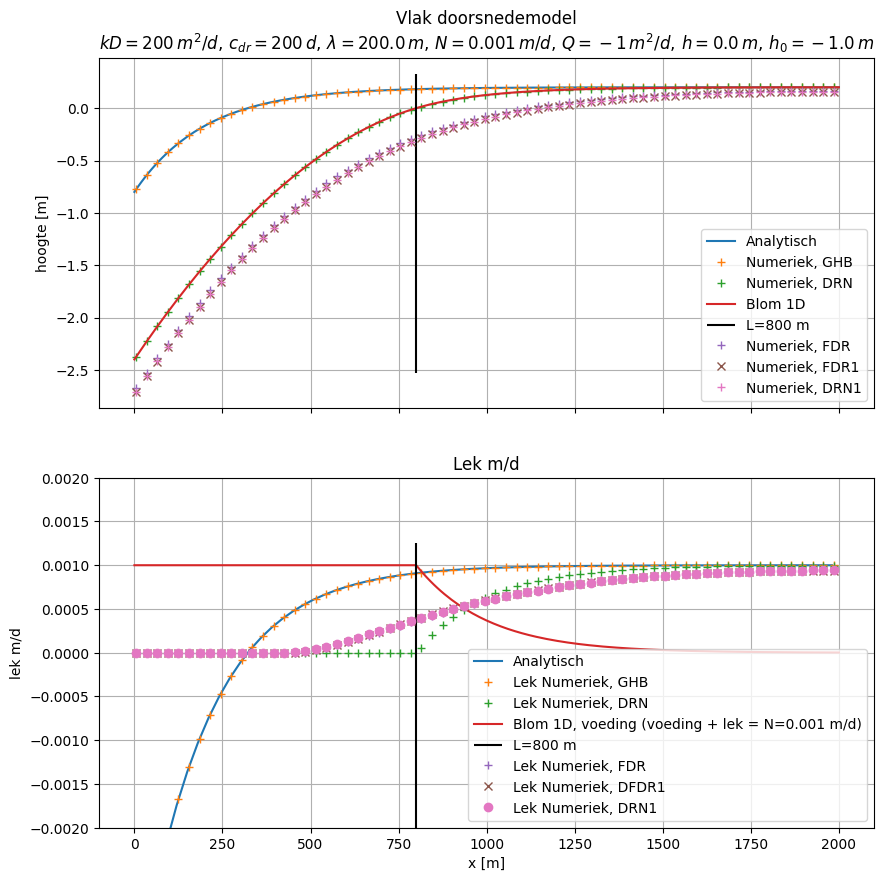

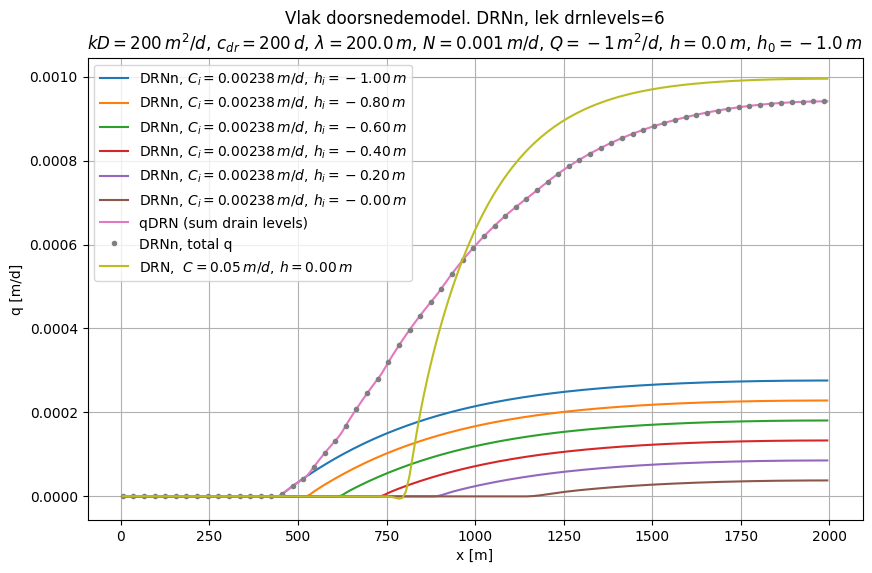

In [233]:
reload(fdm3Blom)
Fdm3 = fdm3Blom.Fdm3

k, D, cdr, N, h, h0, w, L = 10, 20, 200, 0.001, 0., -1.0, 1.0, 100.
phiN = h + N * cdr
lambda_ = np.sqrt(k * D * cdr)

x = np.linspace(0, 2000., 201)
gr = Grid(x, [-0.5, 0.5], [0., -D], axial=False)

S = gr.const(0.001)
IBOUND = gr.const(1)
HI = gr.const(h + N * cdr)
FQ = gr.const(N) * gr.AREA
Q =  -0.5 * FQ.sum()
FQ[-1, 0, 0] += Q

mdl = Fdm3(gr=gr, K=gr.const(k), c=None, S=S, IBOUND=IBOUND, HI=HI, FQ=FQ)

GHB = np.zeros(gr.nx, dtype=Fdm3.dtype['ghb'])
GHB['Ig'], GHB['h'], GHB['C'] = gr.NOD[0, 0, :], h, gr.Area.ravel() / cdr
DRN = GHB.copy()

# Mupltiple drains in cells to simulate a conductance depending on the head

drnlevels = 6
hdr = np.linspace(h0, phiN, drnlevels + 1)[:-1]
c = (phiN - h0) / N
C = 1 / c * (phiN - h0) / (phiN - np.mean(hdr)) / drnlevels
Ig = gr.NOD[0].flatten()
DRNn = np.zeros(drnlevels * gr.nx, dtype=Fdm3.dtype['drn'])
for i, hi in enumerate(hdr):
    i1, i2 = i * len(Ig), (i+1) * len(Ig)  
    DRNn['Ig'][i1:i2] = Ig
    DRNn['h' ][i1:i2] = hi
    DRNn['C' ][i1:i2] = gr.Area.flatten() * C

FDR = np.zeros(gr.nx, dtype=Fdm3.dtype['fdr'])
FDR['Ig'], FDR['phi'], FDR['h'], FDR['h0'], FDR['N'] = gr.NOD[0, 0, :], h + N * cdr, h, h0, N

FDR1 = FDR.copy()
FDR1['w'], FDR1['L'] = w, L

out_ghb = mdl.simulate(GHB=GHB)
out_drn = mdl.simulate(DRN=DRN)
out_fdr = mdl.simulate(FDR=FDR)
out_fdr1 = mdl.simulate(FDR=FDR1)
out_drn1 = mdl.simulate(DRN=DRNn)

fig,(ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10, 10))

title = ("Vlak doorsnedemodel\n" + 
         rf"$kD={k * D}\,m^2/d,\,c_{{dr}}={cdr}\,d,\,\lambda={np.sqrt(k * D * cdr)}\,m,\,N={N}\,m/d,\,Q={Q:.3g}\,m^2/d,\,h={h}\,m,\,h_0={h0}\,m$"
)
ax1.set(title=title, ylabel='hoogte [m]')
ax2.set(title='Lek m/d', xlabel='x [m]', ylabel='lek m/d')
ax1.grid()
ax2.grid()

phi = h + Q * np.sqrt(lambda_ / kD) * np.exp(-gr.x / lambda_) + N * cdr
dqdx = Q / lambda_ * np.exp(-x / lambda_)

Bl = wf.Blom1D(aqprops={'kD':k * D, 'c': cdr})

ax1.plot(gr.x, phi, label="Analytisch")
ax1.plot(gr.xm[::3], out_ghb['Phi'][-1, 0][::3], '+', label="Numeriek, GHB")
ax1.plot(gr.xm[::3], out_drn['Phi'][-1, 0][::3], '+', label="Numeriek, DRN")
ax1.plot(gr.x, N * cdr -Bl.dd(Q=-Q, x=gr.x, N=N), label="Blom 1D")

ax2.plot(gr.x[::3], dqdx[::3] + N, label="Analytisch") # dqdx is infiltratie, N ook dus hetzelfde teken.
ax2.plot(gr.xm[::3], out_ghb['GHB']['q'][::3], '+', label="Lek Numeriek, GHB")
ax2.plot(gr.xm[::3], out_drn['DRN']['q'][::3], '+', label="Lek Numeriek, DRN")
ax2.plot(gr.x, Bl.q(Q=-Q, x=gr.x, N=N), label=f"Blom 1D, voeding (voeding + lek = N={N} m/d)")

L = Bl.getL(Q=Q, N=N)
ymin, ymax = ax1.get_ylim()
ax1.vlines([L], ymin=ymin, ymax=ymax, colors='k', label=f"L={L:.4g} m")
ymin, ymax = ax2.get_ylim()
ax2.vlines([L], ymin=ymin, ymax=ymax, colors='k', label=f"L={L:.4g} m")

ax2.set_ylim(-2 * N, 2 * N)
ax1.legend()
ax2.legend(loc='lower right')

fig.savefig(os.path.join('images', 'example_fdm3_1D.png'))

ax1.plot(gr.xm[::3], out_fdr['Phi'][-1, 0][::3], '+', label="Numeriek, FDR")
ax1.plot(gr.xm[::3], out_fdr1['Phi'][-1, 0][::3], 'x', label="Numeriek, FDR1")
ax2.plot(gr.xm[::3], out_fdr['FDR']['q'][::3], '+', label="Lek Numeriek, FDR")
ax2.plot(gr.xm[::3], out_fdr1['FDR']['q'][::3], 'x', label="Lek Numeriek, DFDR1")

ax1.legend()
ax2.legend(loc="lower right")

fig.savefig(os.path.join('images', 'example_fdm3_1D+FDR.png'))

ax1.plot(gr.xm[::3], out_drn1['Phi'][-1, 0][::3], '+', label="Numeriek, DRN1")

qdrn1 = np.zeros(gr.nx)
np.add.at(qdrn1, out_drn1['DRN']['Ig'], out_drn1['DRN']['q'])
ax2.plot(gr.xm[::3], qdrn1[::3], 'o', label="Lek Numeriek, DRN1")
ax1.legend()
ax2.legend(loc='lower right')

fig.savefig(os.path.join('images', 'example_fdm3_1D+FDR+DRN1.png'))

# Drain discharge
fig, ax = plt.subplots(figsize=(10, 6))
ax.set(title=f"Vlak doorsnedemodel. DRNn, lek drnlevels={drnlevels}\n" +
       rf"$kD={k * D}\,m^2/d,\,c_{{dr}}={cdr}\,d,\,\lambda={np.sqrt(k * D * cdr)}\,m,\,N={N}\,m/d,\,Q={Q:.3g}\,m^2/d,\,h={h}\,m,\,h_0={h0}\,m$",
       xlabel="x [m]", ylabel="q [m/d]")
Ig = gr.NOD[0].flatten()
qtot = np.zeros(len(Ig), dtype=float)
drn1 = out_drn1['DRN']
for i1 in np.arange(0, len(drn1), len(Ig)):
    i2 = i1+ len(Ig)
    ax.plot(gr.xm, drn1['q'][i1:i2], label=fr"DRNn, $C_i={drn1['C'][i1:i2].mean():.3g}\,m/d,\,h_i={drn1['h'][i1:i2].mean():.2f}\,m$")
    qtot += drn1['q'][i1:i2]
ax.plot(gr.xm, qtot, label="qDRN (sum drain levels)")
ax.plot(gr.xm[::3], qdrn1[::3], '.', label="DRNn, total q")
ax.plot(gr.xm, out_drn['DRN']['q'], label=fr"DRN,  $C={out_drn['DRN']['C'].mean():.3g}\,m/d,\,h={out_drn['DRN']['h'].mean():.2f}\,m$")
ax.grid()
ax.legend(loc="upper left")

fig.savefig(os.path.join("images", "example_fdm3_1D_DRNn_leakage.png"))

plt.plot


# Axiaal-symmetrische doorsnede

axial==True so that y coordinates and ky are ignored
            and x stands for r, so that all x coordinates must be >= 0.
No outer iterations needed.

===== Water balance of the entire model =====
Model grid = (1, 1, 200)

Sum over all nodal flows should be zero:
Total net in Q1     = -3.0695e-11 m3/d

Boundary components, these components should also add up zo zero:
Fixed flows         FQ   =       11780.972 m3/d
Fixed heads         QFH  =           0.000 m3/d
GHB                Qghb =      -11780.972 m3/d, flow from GHB cells.

Total water balance of this model
Q1 (internal)            =          -0.000 m3/d, total internal flow
Q2 (boundaries)          =           0.000 m3/d, total from boundaries
===== end of water balance =====

Non-linear options: ['DRN'], starting outer iterations:
iouter =    0, err =     1.8718 m, errBalance =    -628.32
iouter =    1, err =    0.40277 m, errBalance =    -962.53
iouter =    2, err =    0.20339 m, errBalance =    -1174.8
iouter =    3, err =

<function matplotlib.pyplot.plot(*args: 'float | ArrayLike | str', scalex: 'bool' = True, scaley: 'bool' = True, data=None, **kwargs) -> 'list[Line2D]'>

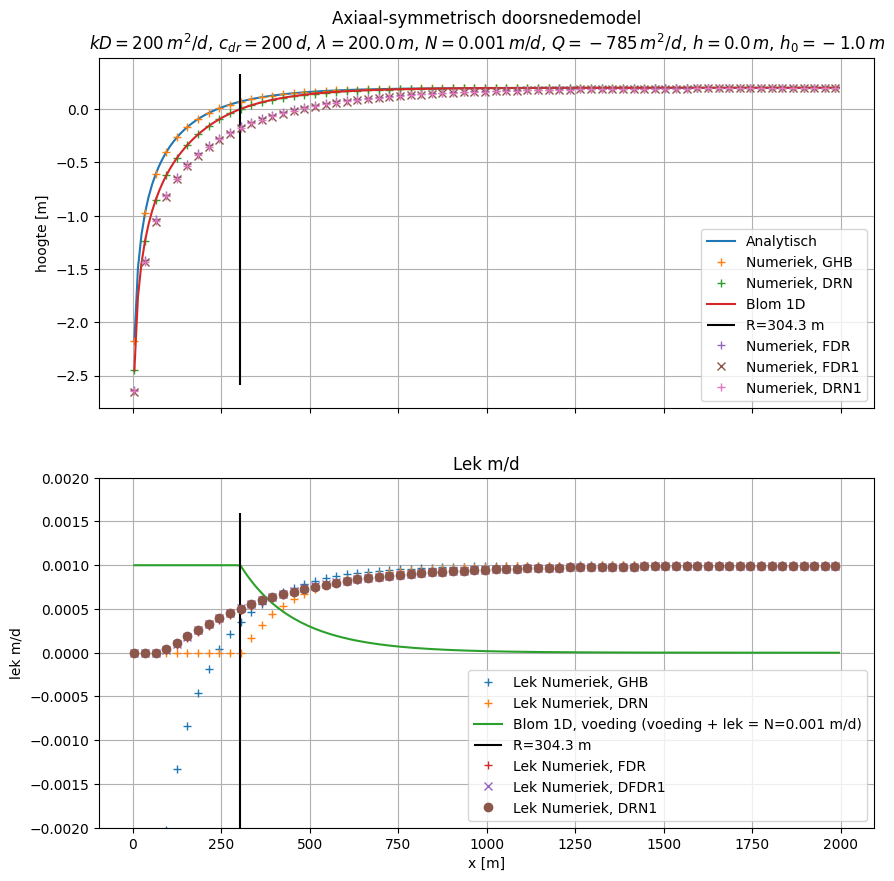

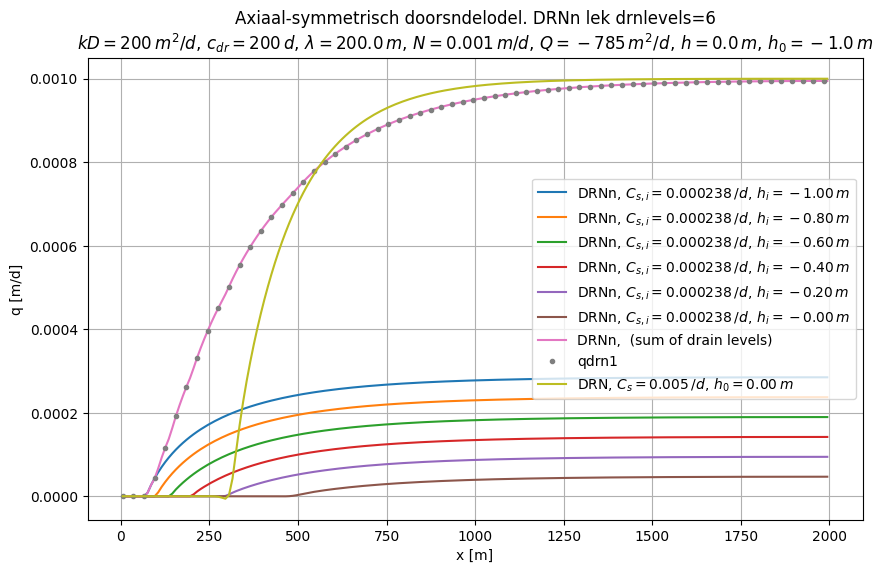

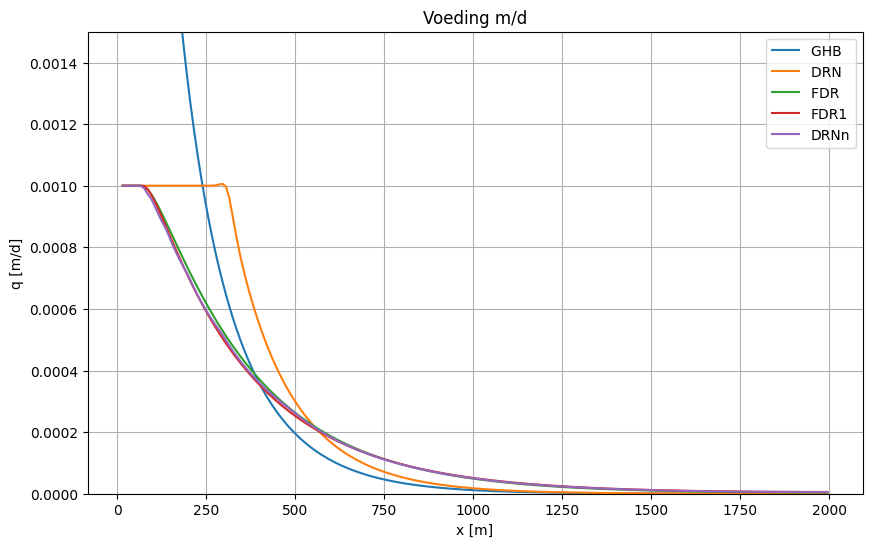

In [12]:
reload(fdm3Blom)
Fdm3 = fdm3Blom.Fdm3

k, D, cdr, N, h, h0, w, L = 10, 20, 200, 0.001, 0., -1.0, 1.0, 100.
phiN = h + N * cdr
lambda_ = np.sqrt(k * D * cdr)

x = np.linspace(0, 2000., 201)
gr = Grid(x, None, [0., -D], axial=True)

S = gr.const(0.001)
IBOUND = gr.const(1)
HI = gr.const(h + N * cdr)
FQ = gr.const(N) * gr.AREA
R = 500.
Q =  -np.sum((gr.const(N) * gr.AREA)[gr.XM < R])
FQ[-1, 0, 0] += Q

mdl = Fdm3(gr=gr, K=gr.const(k), c=None, S=S, IBOUND=IBOUND, HI=HI, FQ=FQ)

GHB = np.zeros(gr.nx, dtype=Fdm3.dtype['ghb'])
GHB['Ig'], GHB['h'], GHB['C'] = gr.NOD[0, 0, :], h, gr.Area.ravel() / cdr
DRN = GHB.copy()

# Mupltiple drains in cells to simulate a conductance depending on the head

drnlevels = 6
hdr = np.linspace(h0, phiN, drnlevels + 1)[:-1]
c = (phiN - h0) / N
C = 1 / c * (phiN - h0) / (phiN - np.mean(hdr)) / drnlevels
Ig = gr.NOD[0].flatten()
DRNn = np.zeros(drnlevels * gr.nx, dtype=Fdm3.dtype['drn'])
for i, hi in enumerate(hdr):
    i1, i2 = i * len(Ig), (i+1) * len(Ig)  
    DRNn['Ig'][i1:i2] = Ig
    DRNn['h' ][i1:i2] = hi
    DRNn['C' ][i1:i2] = gr.Area.flatten() * C

FDR = np.zeros(gr.nx, dtype=Fdm3.dtype['fdr'])
FDR['Ig'], FDR['phi'], FDR['h'], FDR['h0'], FDR['N'] = gr.NOD[0, 0, :], h + N * cdr, h, h0, N

FDR1 = FDR.copy()
FDR1['w'], FDR1['L'] = w, L

out_ghb = mdl.simulate(GHB=GHB)
out_drn = mdl.simulate(DRN=DRN)
out_fdr = mdl.simulate(FDR=FDR)
out_fdr1 = mdl.simulate(FDR=FDR1)
out_drn1 = mdl.simulate(DRN=DRNn)

fig,(ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10, 10))

title = ("Axiaal-symmetrisch doorsnedemodel\n" + 
         rf"$kD={k * D}\,m^2/d,\,c_{{dr}}={cdr}\,d,\,\lambda={np.sqrt(k * D * cdr)}\,m,\,N={N}\,m/d,\,Q={Q:.3g}\,m^2/d,\,h={h}\,m,\,h_0={h0}\,m$"
)
ax1.set(title=title, ylabel='hoogte [m]')
ax2.set(title='Lek m/d', xlabel='x [m]', ylabel='lek m/d')
ax1.grid()
ax2.grid()

phi = h + N * cdr + Q / (2 * np.pi * k * D) * K0 (gr.xm / lambda_)
dqdx = Q / lambda_ * np.exp(-x / lambda_)

Bl = wf.wBlom(aqprops={'kD':k * D, 'c': cdr})

ax1.plot(gr.xm, phi, label="Analytisch")
ax1.plot(gr.xm[::3], out_ghb['Phi'][-1, 0][::3], '+', label="Numeriek, GHB")
ax1.plot(gr.xm[::3], out_drn['Phi'][-1, 0][::3], '+', label="Numeriek, DRN")
ax1.plot(gr.xm, N * cdr -Bl.dd(Q=-Q, x=gr.xm, N=N), label="Blom 1D")

# ax2.plot(gr.x[::3], dqdx[::3] + N, label="Analytisch") # dqdx is infiltratie, N ook dus hetzelfde teken.
ax2.plot(gr.xm[::3], out_ghb['GHB']['q'][::3], '+', label="Lek Numeriek, GHB")
ax2.plot(gr.xm[::3], out_drn['DRN']['q'][::3], '+', label="Lek Numeriek, DRN")
ax2.plot(gr.xm, Bl.q(Q=-Q, x=gr.xm, N=N), label=f"Blom 1D, voeding (voeding + lek = N={N} m/d)")

L = Bl.getR(Q=Q, N=N)
ymin, ymax = ax1.get_ylim()
ax1.vlines([L], ymin=ymin, ymax=ymax, colors='k', label=f"R={L:.4g} m")
ymin, ymax = ax2.get_ylim()
ax2.vlines([L], ymin=ymin, ymax=ymax, colors='k', label=f"R={L:.4g} m")

ax2.set_ylim(-2 * N, 2 * N)
ax1.legend()
ax2.legend(loc='lower right')

fig.savefig(os.path.join('images', 'example_fdm3_axym.png'))

ax1.plot(gr.xm[::3], out_fdr['Phi'][-1, 0][::3], '+', label="Numeriek, FDR")
ax1.plot(gr.xm[::3], out_fdr1['Phi'][-1, 0][::3], 'x', label="Numeriek, FDR1")
ax2.plot(gr.xm[::3], out_fdr['FDR']['q'][::3], '+', label="Lek Numeriek, FDR")
ax2.plot(gr.xm[::3], out_fdr1['FDR']['q'][::3], 'x', label="Lek Numeriek, DFDR1")

ax1.legend()
ax2.legend(loc="lower right")

fig.savefig(os.path.join('images', 'example_fdm3_axym+FDR.png'))

ax1.plot(gr.xm[::3], out_drn1['Phi'][-1, 0][::3], '+', label="Numeriek, DRN1")

qdrn1 = np.zeros(gr.nx)
np.add.at(qdrn1, out_drn1['DRN']['Ig'], out_drn1['DRN']['q'])
ax2.plot(gr.xm[::3], qdrn1[::3], 'o', label="Lek Numeriek, DRN1")
ax1.legend()
ax2.legend(loc='lower right')

fig.savefig(os.path.join('images', 'example_fdm3_axym+FDR+DRN1.png'))

# Drain discharge
fig, ax = plt.subplots(figsize=(10, 6))
ax.set(title=f"Axiaal-symmetrisch doorsndelodel. DRNn lek drnlevels={drnlevels}\n" +
       rf"$kD={k * D}\,m^2/d,\,c_{{dr}}={cdr}\,d,\,\lambda={np.sqrt(k * D * cdr)}\,m,\,N={N}\,m/d,\,Q={Q:.3g}\,m^2/d,\,h={h}\,m,\,h_0={h0}\,m$",
       xlabel="x [m]", ylabel="q [m/d]")
Ig = gr.NOD[0].flatten()
qtot = np.zeros(len(Ig), dtype=float)
drn1 = out_drn1['DRN']
for i1 in np.arange(0, len(drn1), len(Ig)):
    i2 = i1 + len(Ig)
    Ci = (drn1['C'][i1:i2] / gr.AREA.ravel()[Ig]).mean()
    hi = drn1['h'][i1:i2].mean()
    ax.plot(gr.xm, drn1['q'][i1:i2], label=fr"DRNn, $C_{{s,i}}={Ci:.3g}\,/d,\,h_i={hi:.2f}\,m$")
    qtot += drn1['q'][i1:i2]
ax.plot(gr.xm, qtot, label=fr"DRNn,  (sum of drain levels)")
ax.plot(gr.xm[::3], qdrn1[::3], '.', label="qdrn1")
drn = out_drn['DRN']
Cs = (drn['C'] / gr.AREA.ravel()[drn['Ig']]).mean()
h_ =  drn['h'].mean()
ax.plot(gr.xm, out_drn['DRN']['q'], label=fr"DRN, $C_s={Cs:.3g}\,/d,\,h_0={h_:.2f}\,m$")
ax.grid()
ax.legend(loc="center right")

fig.savefig(os.path.join("images", "example_fdm3_axym_DRNn_leakage.png"))

fig, ax = plt.subplots(figsize=(10, 6))
ax.set(title="Voeding m/d", xlabel="x [m]", ylabel="q [m/d]")

ax.plot(gr.xm[1:], out_ghb['Q' ][0, 0, 1:] / gr.AREA[0, 0, 1:], label="GHB ")
ax.plot(gr.xm[1:], out_drn['Q' ][0, 0, 1:] / gr.AREA[0, 0, 1:], label="DRN ")
ax.plot(gr.xm[1:], out_fdr['Q' ][0, 0, 1:] / gr.AREA[0, 0, 1:], label="FDR ")
ax.plot(gr.xm[1:], out_fdr1['Q'][0, 0, 1:] / gr.AREA[0, 0, 1:], label="FDR1")
ax.plot(gr.xm[1:], out_drn1['Q'][0, 0, 1:] / gr.AREA[0, 0, 1:], label="DRNn")
ax.set_ylim(0, 1.5e-3)
ax.grid()
ax.legend()

fig.savefig(os.path.join("images", "example_fdm3_axym_voeding.png"))

plt.plot
